In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [20]:
#change the path for local imports 
import os
os.chdir('/content/drive/MyDrive/BiasMitigation/LNTL')
print('Changed the local path to....', os.getcwd())

Changed the local path to.... /content/drive/MyDrive/BiasMitigation/LNTL


In [23]:
''' 
    The following script changes the instance segmentation ground truth
    labels in the SYNTHIA dataset to semantic segmentation labels by extracting 
    the first channel of the label images. It then changes the pixel id's in the 
    labels to correspond exactly to the cityscapes mapping for fair comparisons 
    between results of both datasets.

    Next the class weights are computed using the same method for the cityscapes
    datatset. The next code block then creates a 70/30 split of training and 
    validation images within our file structure. 
'''
# Imports:
import torch
import torch.utils.data
import torchvision.transforms as T

import pickle 
import numpy as np
import cv2
import os
import shutil

from google.colab.patches import cv2_imshow
!pip install imageio
import imageio

! pip install import-ipynb 
import import_ipynb
from utils.utils_SYNTHIA import *

# This is necessary to read in images in correct format, CV2 doesnt work.
imageio.plugins.freeimage.download()

#label_test = np.asarray(imageio.imread(gt_train +'/'+ test_label_image, format='PNG-FI'))


img_path = '/content/drive/MyDrive/BiasMitigation/Datasets/SYNTHIA/RGB'
gt_path = '/content/drive/MyDrive/BiasMitigation/Datasets/SYNTHIA/GT'


if not os.path.exists(gt_path + '/' + 'SEMANTIC_LABELS'):
    os.makedirs(gt_path + '/' + 'SEMANTIC_LABELS')
if not os.path.exists(gt_path + '/' + 'COLOUR_CITYSCAPES'):
    os.makedirs(gt_path + '/' + 'COLOUR_CITYSCAPES')

label_img_paths = [] # Used for the class weights below

gt_instance_label_imgs = os.listdir(gt_path + '/LABELS')

# label images in the *cityscapes-rand-synthia* dataset are for instance segmentation so we have to strip out the 
# first channel of the label image and reproduce the coloured ground truth images for semantic segmentation

for i, file in enumerate(sorted(gt_instance_label_imgs)):

    gt_label = np.asarray(imageio.imread(gt_path +'/LABELS/'+ file, format='PNG-FI'))
    
    gt = gt_label[:,:,0].astype(np.uint8) # crucial line for saving
    gt_converted = id_to_trainId_map_func(gt)

    cv2.imwrite( gt_path + '/' + 'SEMANTIC_LABELS/' + file , gt_converted)
    
    # Use utils function to convert the pixels to the cityscapes colours
    # save images in the directory we created. 
    img_colour = label_img_to_color_BGR(gt_converted)
    #cv2_imshow(img_colour)
    cv2.imwrite( gt_path + '/' + 'COLOUR_CITYSCAPES/' + file , img_colour)

    label_img_paths.append( gt_path + '/' + 'SEMANTIC_LABELS/' + file )

    if i % 500 == 0:
        print('Progress: We have copied  ' , i, '/9400  images....sit tight!')

print('Semantic Labels and Cityscapes Mapped Colour Images Complete!')


################################################################################
# compute the class weights:
################################################################################
print ("computing class Weights")

num_classes = 20

trainId_to_count = {}
for trainId in range(num_classes):
    trainId_to_count[trainId] = 0

# get the total number of pixels in all train label_imgs that are of each object class:
for step, label_img_path in enumerate(label_img_paths):
    if step % 100 == 0:
        print (step)

    label_img = cv2.imread(label_img_path, -1)

    for trainId in range(num_classes):
        # count how many pixels in label_img which are of object class trainId:
        trainId_mask = np.equal(label_img, trainId)
        trainId_count = np.sum(trainId_mask)

        # add to the total count:
        trainId_to_count[trainId] += trainId_count

# compute the class weights according to the ENet paper:
class_weights = []
total_count = sum(trainId_to_count.values())
for trainId, count in trainId_to_count.items():
    trainId_prob = float(count)/float(total_count)
    trainId_weight = 1/np.log(1.02 + trainId_prob)
    class_weights.append(trainId_weight)

print (class_weights)

with open(gt_path + "/class_weights.pkl", "wb") as file:
    pickle.dump(class_weights, file)

print('Proceedure Complete!')

Progress: We have copied   0 /9400  images....sit tight!
Progress: We have copied   500 /9400  images....sit tight!
Progress: We have copied   1000 /9400  images....sit tight!
Progress: We have copied   1500 /9400  images....sit tight!
Progress: We have copied   2000 /9400  images....sit tight!
Progress: We have copied   2500 /9400  images....sit tight!
Progress: We have copied   3000 /9400  images....sit tight!
Progress: We have copied   3500 /9400  images....sit tight!
Progress: We have copied   4000 /9400  images....sit tight!
Progress: We have copied   4500 /9400  images....sit tight!
Progress: We have copied   5000 /9400  images....sit tight!
Progress: We have copied   5500 /9400  images....sit tight!
Progress: We have copied   6000 /9400  images....sit tight!
Progress: We have copied   6500 /9400  images....sit tight!
Progress: We have copied   7000 /9400  images....sit tight!
Progress: We have copied   7500 /9400  images....sit tight!
Progress: We have copied   8000 /9400  image

In [ ]:
''' 
    The following block organises the file structure of the SYNTHIA dataset 
    into a train test split from the images we have just created above. 
    
    The split is roughly 70% train, 30% validation containing
    6500 and 2900 images respectively. Image sizes are 760 x 1280 
'''

#SYNTHIA directory

img_path = '/content/drive/MyDrive/BiasMitigation/Datasets/SYNTHIA/RGB'
gt_path = '/content/drive/MyDrive/BiasMitigation/Datasets/SYNTHIA/GT/SEMANTIC_LABELS'
colour_path = '/content/drive/MyDrive/BiasMitigation/Datasets/SYNTHIA/GT/COLOUR_CITYSCAPES'

# file_list = sorted(os.listdir(img_path))

# train_imgs = file_list[:6500]
# val_imgs = file_list[6500:]

## train
train_dir_imgs = img_path + '/train'
train_dir_gt = gt_path + '/train'
train_dir_colour = colour_path +'/train'
## val
val_dir_imgs = img_path + '/val'
val_dir_gt = gt_path + '/val'
val_dir_colour = colour_path +'/val'

## train
if not os.path.exists(train_dir_imgs):
    os.makedirs(train_dir_imgs)
if not os.path.exists(train_dir_gt):
    os.makedirs(train_dir_gt) 
if not os.path.exists(train_dir_colour):
    os.makedirs(train_dir_colour)   
## val
if not os.path.exists(val_dir_imgs):
    os.makedirs(val_dir_imgs)
if not os.path.exists(val_dir_gt):
    os.makedirs(val_dir_gt)
if not os.path.exists(val_dir_colour):
    os.makedirs(val_dir_colour)

print('Directories created for train and val!')

#delete after run:
train_imgs = sorted(os.listdir(train_dir_imgs))
val_imgs = sorted(os.listdir(val_dir_imgs))


# move the files into train and val directories for the dataloaders
for filename in train_imgs:
    #shutil.move(img_path + '/' +  filename, train_dir_imgs + '/' +  filename)
    shutil.move(gt_path + '/' +  filename, train_dir_gt + '/' +  filename)
    shutil.move(colour_path + '/' +  filename, train_dir_colour + '/' +  filename)
print('Training imgs and gt moved to train directory')
for filename in val_imgs:  
    #shutil.move(img_path + '/' + filename, val_dir_imgs +  '/' + filename)
    shutil.move(gt_path + '/' +  filename, val_dir_gt + '/' + filename)
    shutil.move(colour_path + '/' +  filename, val_dir_colour + '/' + filename)
print('Validation imgs and gt moved to train directory')


print('Proceedure complete!')



Directories created for train and val!


In [ ]:
# Sanity Checks
img_train = '/content/drive/MyDrive/BiasMitigation/Datasets/SYNTHIA/RGB/train'
gt_train = '/content/drive/MyDrive/BiasMitigation/Datasets/SYNTHIA/GT/SEMANTIC_LABELS/train'
colour_train = '/content/drive/MyDrive/BiasMitigation/Datasets/SYNTHIA/GT/COLOUR_CITYSCAPES/train'
img_val = '/content/drive/MyDrive/BiasMitigation/Datasets/SYNTHIA/RGB/val'
gt_val = '/content/drive/MyDrive/BiasMitigation/Datasets/SYNTHIA/GT/SEMANTIC_LABELS/val'
colour_val = '/content/drive/MyDrive/BiasMitigation/Datasets/SYNTHIA/GT/COLOUR_CITYSCAPES/val'
##~~~
print(len(os.listdir(img_train)))
print(len(os.listdir(gt_train)))
print(len(os.listdir(colour_train)))
##~~~
print(len(os.listdir(img_val)))
print(len(os.listdir(gt_val)))
print(len(os.listdir(colour_val)))

6500
6500
6500
2900
2900
2900


In [ ]:
print(sorted(os.listdir(img_train)) == sorted(os.listdir(gt_train)) == sorted(os.listdir(colour_train)))
print(sorted(os.listdir(img_val)) == sorted(os.listdir(gt_val)) == sorted(os.listdir(colour_val)))

True
True


In [ ]:
for file in os.listdir(colour_train):
    if file == '0003897.png':
        print('Aye its there like')


#sum(os.listdir(gt_train) == '0003897.png')

Aye its there like


In [ ]:
file_train = os.listdir(img_train)
train_gt = os.listdir(gt_train)
file_val = os.listdir(img_val)
val_gt = os.listdir(gt_val)
print(file_train == train_gt)
file_val == val_gt

True


True

In [ ]:
sum = 0

for filename in train_gt:
    for files in val_gt:
        if filename == files:
            sum = sum+1
print(sum)

0


In [ ]:
for filename in file_val:
    if filename == '0000000.png':
        print('True')


True


In [ ]:
sorted(file_val)[-1]

'0003459.png'

In [ ]:
img_train + '/'+ os.listdir(img_train)[0]

'/content/drive/MyDrive/BiasMitigation/Datasets/SYNTHIA/RGB/train/0005711.png'

In [ ]:
import cv2 

# size check SYNTHIA:
img = cv2.imread(img_train + '/' + os.listdir(img_train)[1])
#height, width, channels = img.shape
print(img.shape)

# gt label check:
img = cv2.imread(gt_train + '/' + os.listdir(gt_train)[1])
#height, width, channels = img.shape
print(img.shape)

(760, 1280, 3)
(760, 1280, 3)


In [ ]:
# label images in the cityscapes synthia are for instance segmentation so we have to strip out the 
# first channel of the label image and reproduce the coloured ground truth images for semantic segmentation

import torch
import torch.utils.data
import torchvision.transforms as T

import numpy as np
import cv2
import os
import shutil

img_train = '/content/drive/MyDrive/BiasMitigation/Datasets/SYNTHIA/RGB/train'
gt_train = '/content/drive/MyDrive/BiasMitigation/Datasets/SYNTHIA/GT/LABELS/train'
img_val = '/content/drive/MyDrive/BiasMitigation/Datasets/SYNTHIA/RGB/val'
gt_val = '/content/drive/MyDrive/BiasMitigation/Datasets/SYNTHIA/GT/LABELS/val'

In [ ]:
import numpy as np
gt_train = '/content/drive/MyDrive/BiasMitigation/Datasets/SYNTHIA/GT/LABELS'
test_label_image = sorted(os.listdir(gt_train))[1]

print(test_label_image)
label = cv2.imread(gt_train +'/'+ test_label_image)
print(label.shape)

print(label[:,:,2])
third_chan = label[:,:,2]

print(third_chan.sum() == 0) #True so the last channel is unused. all zeros

second_chan = label[:,:,1]

print(np.max(second_chan))
print(np.unique(second_chan))


first_chan = label[:,:,1]
print(first_chan.shape)
print(np.max(first_chan))
print(np.unique(first_chan))

0000001.png
(760, 1280, 3)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
True
3
[0 1 2 3]
(760, 1280)
3
[0 1 2 3]


In [ ]:
!pip install imageio

import imageio

imageio.plugins.freeimage.download()

label_test = np.asarray(imageio.imread(gt_train +'/'+ test_label_image, format='PNG-FI'))

In [ ]:
label_test.shape

range(0,label_test.shape[0])

range(0, 760)

In [ ]:
print(label_test[:,:,2].sum() )

for i in range(0, label_test.shape[0]):
    for j in range(0,label_test.shape[1]):
        if label_test[i,j,2] != 0:
            print(i, j)
            

0


In [ ]:
print(label_test[:,:,1].max())

<built-in method max of numpy.ndarray object at 0x7f2580d554e0>


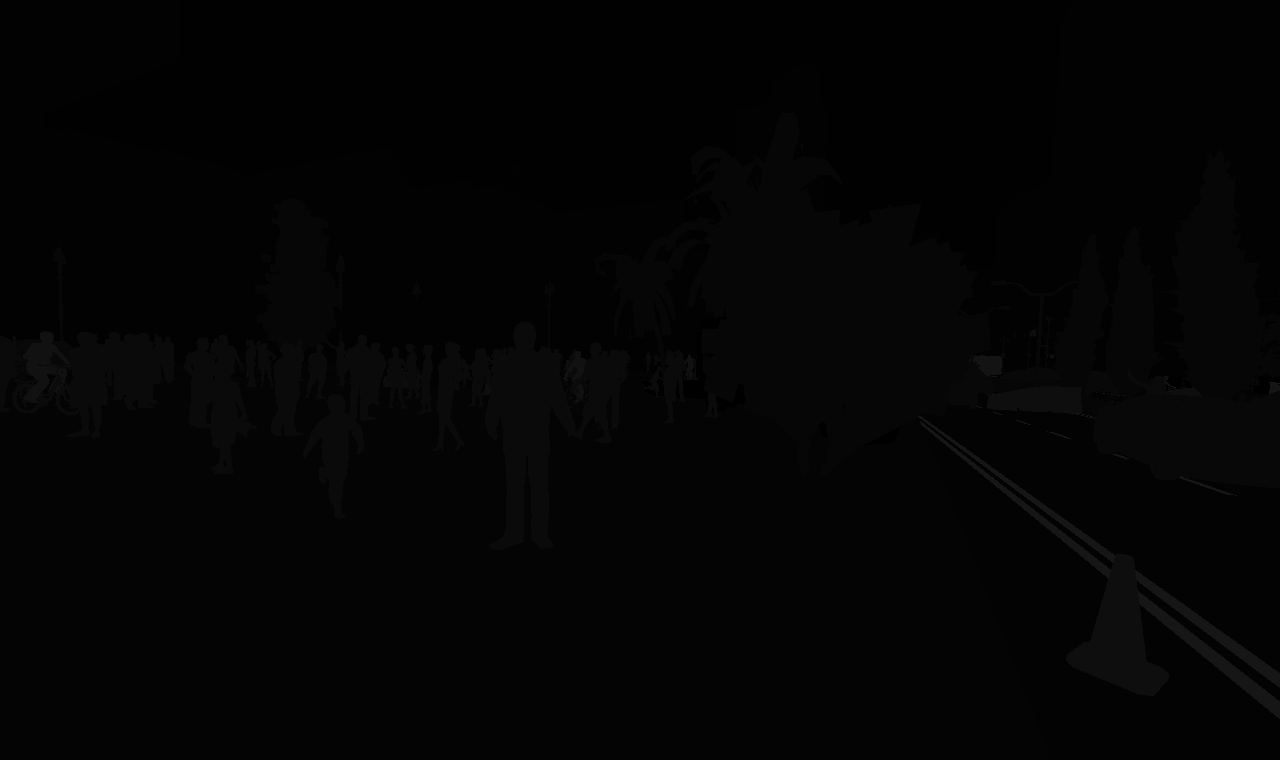

In [ ]:
from google.colab.patches import cv2_imshow

cv2_imshow(label_test[:,:,0])

In [ ]:
print(np.unique(label_test[:,:,0])) # this is the label image we need. must add into the dataloader script. 
print(np.unique(label_test[:,:,1]))

[ 0  1  2  3  4  6  7  8  9 10 11 12 14 15 17 19 21 22]
[  0  23  27  28  43  48  67  74  81  82 102 119 127 140 147 149 176 181
 208 212 218 219 239 242 254 260 261 274 283 286 309 314 329 338 361 363
 383 408 435 444 449 451 453 482 483 492 498 515 527 550 554 570 575 600
 608 626 636 646 652 663 671 675 681 682 690 695 711 712 733 741 743 781
 785 795 797 818 820 837 843 857 863 865 866 869 872 873 889 892 894 918
 920 923 932 941 957 964 972]


In [ ]:
# attempt to colourise the images in the cityscapes palette to show semantic segmentation:

def label_img_to_color_BGR(img):
    label_to_color = {
        0:  [128, 64,128],
        1:  [232, 35,244],
        2:  [ 70, 70, 70],
        3:  [156,102,102],
        4:  [153,153,190],
        5:  [153,153,153],
        6:  [30 ,170,250],
        7:  [  0,220,220],
        8:  [35 ,142,107],
        9:  [152,251,152],
        10: [180,130, 70],
        11: [ 60, 20,220],
        12: [  0,  0,255],
        13: [142,  0,  0],
        14: [ 70,  0,  0],
        15: [100, 60,  0],
        16: [100, 80,  0],
        17: [230,  0,  0],
        18: [ 32, 11,119],
        19: [81,  0,  81],
        20
        }

    img_height, img_width = img.shape

    img_color = np.zeros((img_height, img_width, 3))
    for row in range(img_height):
        for col in range(img_width):
            label = img[row, col] #this cycles through the whole array of predicted values and grabs the label at that point

            img_color[row, col] = np.array(label_to_color[label]) # this slots in the colour vector for the specific label from the list above 

    return img_color

In [ ]:
def label_img_to_color_SYNTHIA_RGB(img):
    label_to_color = {
        0:  [   0,   0,   0],   # void
        1:  [  70, 130, 180],   # sky 
        2:  [  70,  70,  70],   # building
        3:  [ 128,  64, 128],   # road
        4:  [ 244,  35, 232],   # sidewalk
        5:  [  64,  64, 128],   # fence
        6:  [ 107, 142,  35],   # vegetation
        7:  [ 153, 153, 153],   # pole
        8:  [   0,   0, 142],   # car
        9:  [ 220, 220,   0],   # traffic sign
        10: [ 220,  20,  60],   # pedestrian
        11: [ 119,  11,  32],   # bicycle
        12: [   0,   0, 230],   # motorcycle
        13: [ 250, 170,  30],   # parking slot
        14: [ 128,  64,  64],   # road work
        15: [ 250, 170,  30],   # traffic light
        16: [ 152, 251, 152],   # terrain
        17: [ 255,   0,   0],   # rider
        18: [   0,   0,  70],   # truck
        19: [   0,  60, 100],   # bus
        20: [   0,  80, 100],   # train
        21: [ 102, 102, 156],   # wall
        22: [ 102, 102, 156]    # lanemarking
        }

    img_height, img_width = img.shape

    img_color = np.zeros((img_height, img_width, 3))
    for row in range(img_height):
        for col in range(img_width):
            label = img[row, col] #this cycles through the whole array of predicted values and grabs the label at that point

            img_color[row, col] = np.array(label_to_color[label]) # this slots in the colour vector for the specific label from the list above 

    return img_color

In [13]:
def label_img_to_color_SYNTHIA_BGR(img):
    label_to_color = {
        0:  [   0,   0,   0],   # void
        1:  [ 180, 130,  70],   # sky 
        2:  [  70,  70,  70],   # building
        3:  [ 128,  64, 128],   # road
        4:  [ 232,  35, 244],   # sidewalk
        5:  [ 128,  64,  64],   # fence
        6:  [  35, 142, 107],   # vegetation
        7:  [ 153, 153, 153],   # pole
        8:  [ 142,   0,   0],   # car
        9:  [   0, 220, 220],   # traffic sign
        10: [  60,  20, 220],   # pedestrian
        11: [  32,  11, 119],   # bicycle
        12: [ 230,   0,   0],   # motorcycle
        13: [  30, 170, 250],   # parking slot ---> not in cityscapes
        14: [  64,  64, 128],   # road work    ---> not in cityscapes
        15: [  30, 170, 250],   # traffic light
        16: [ 152, 251, 152],   # terrain
        17: [   0,   0, 255],   # rider
        18: [  70,   0,   0],   # truck
        19: [ 100,  60,   0],   # bus
        20: [ 100,  80,   0],   # train
        21: [ 156, 102, 102],   # wall
        22: [ 156, 102, 102]    # lanemarking ---> not in cityscapes
        }

    img_height, img_width = img.shape

    img_color = np.zeros((img_height, img_width, 3))
    for row in range(img_height):
        for col in range(img_width):
            label = img[row, col] #this cycles through the whole array of predicted values and grabs the label at that point

            img_color[row, col] = np.array(label_to_color[label]) # this slots in the colour vector for the specific label from the list above 

    return img_color

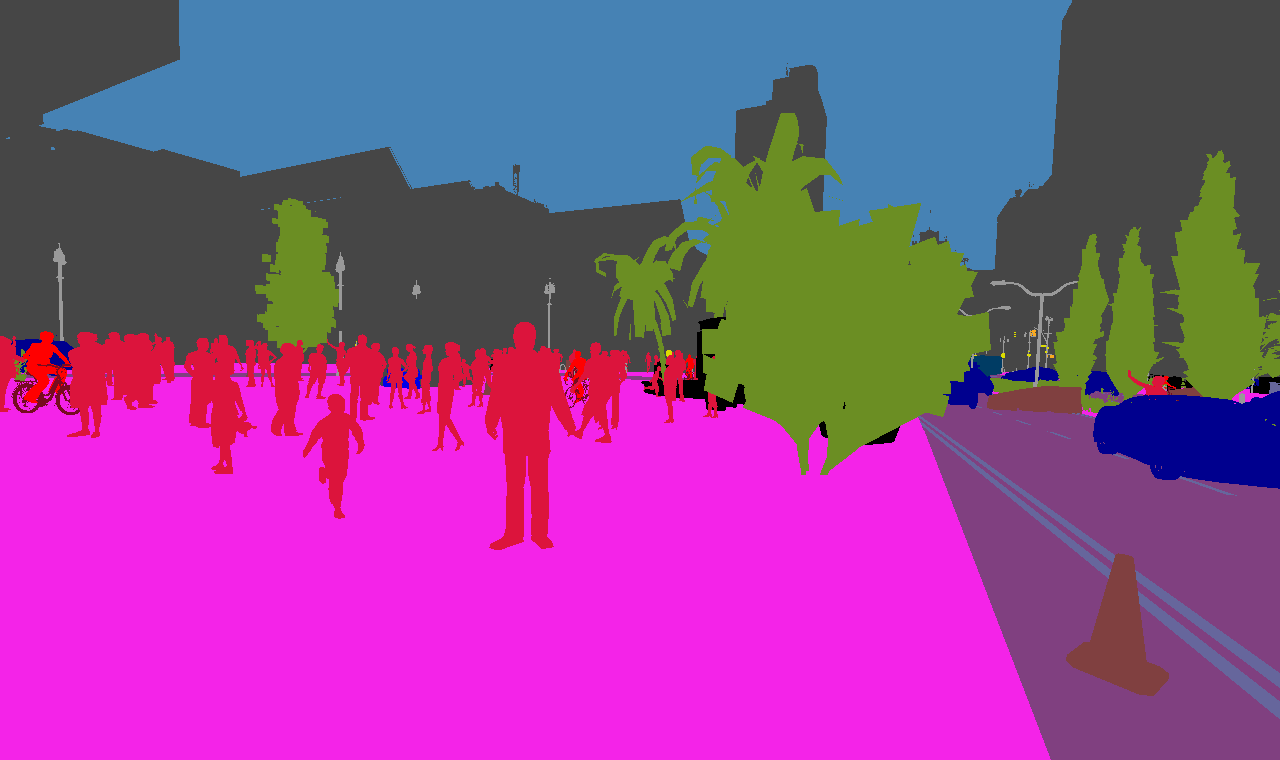

In [ ]:
img_colour = label_img_to_color_SYNTHIA_BGR(label_test[:,:,0])
cv2_imshow(img_colour)

In [ ]:
# if we want to match it up with cityscapes exactly then we can change lanemarkings ----> road, parking slot ----> road, road works ----> void

#label_test[:,:,0]
label_test[:,:,0][label_test[:,:,0] == 22] = 3  # lanemarkings ----> road
label_test[:,:,0][label_test[:,:,0] == 13] = 3  # parking slot ----> road
label_test[:,:,0][label_test[:,:,0] == 14] = 0  # road works ----> void

In [ ]:
np.unique(label_test[:,:,0])

array([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 15, 17, 19, 21],
      dtype=uint16)

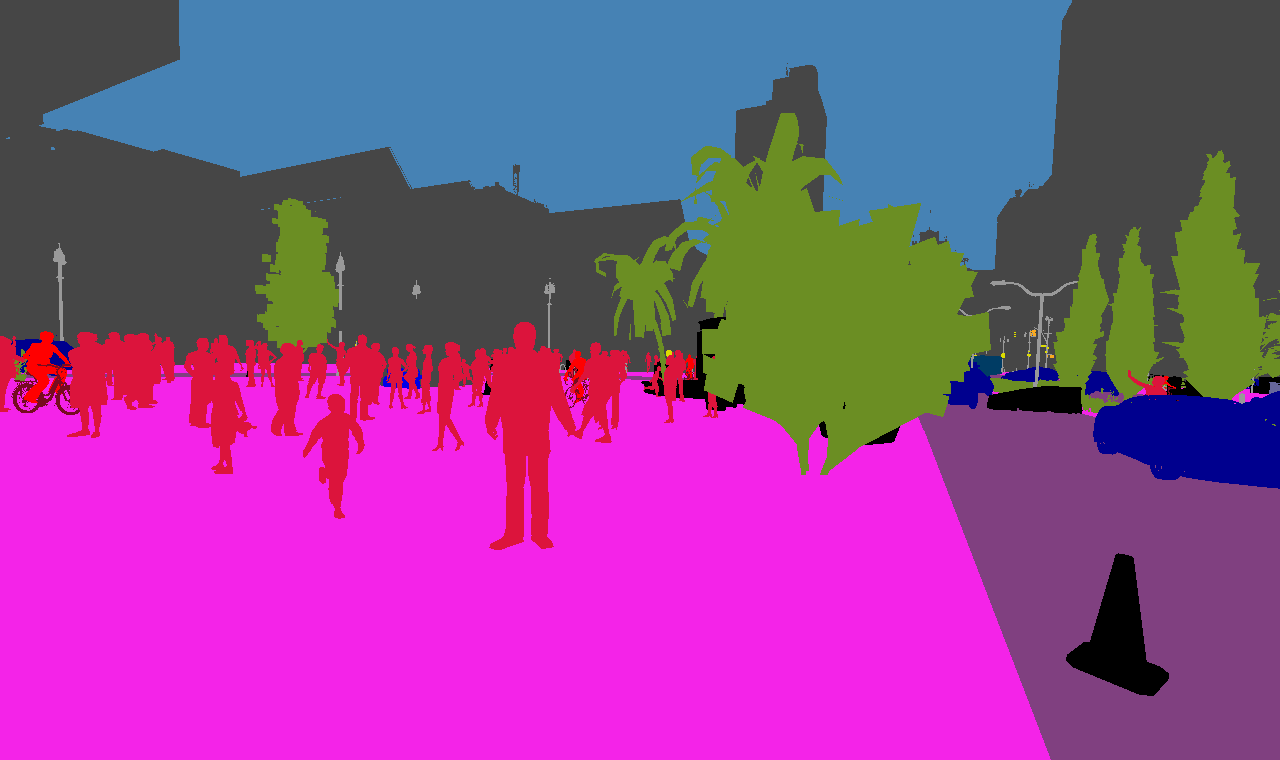

In [ ]:
img_colour = label_img_to_color_SYNTHIA_BGR(label_test[:,:,0])
cv2_imshow(img_colour)

In [ ]:
test_image = os.listdir('/content/drive/MyDrive/BiasMitigation/Datasets/SYNTHIA/GT/SEMANTIC_LABELS')[0]

test = cv2.imread('/content/drive/MyDrive/BiasMitigation/Datasets/SYNTHIA/GT/SEMANTIC_LABELS/' + test_image )


In [ ]:
np.unique(test)

array([0, 1, 2, 3, 4], dtype=uint8)

In [ ]:
test_image = os.listdir('/content/drive/MyDrive/BiasMitigation/Datasets/SYNTHIA/GT/COLOUR_CITYSCAPES')[0]
test_image

test = cv2.imread('/content/drive/MyDrive/BiasMitigation/Datasets/SYNTHIA/GT/COLOUR_CITYSCAPES/' + test_image)

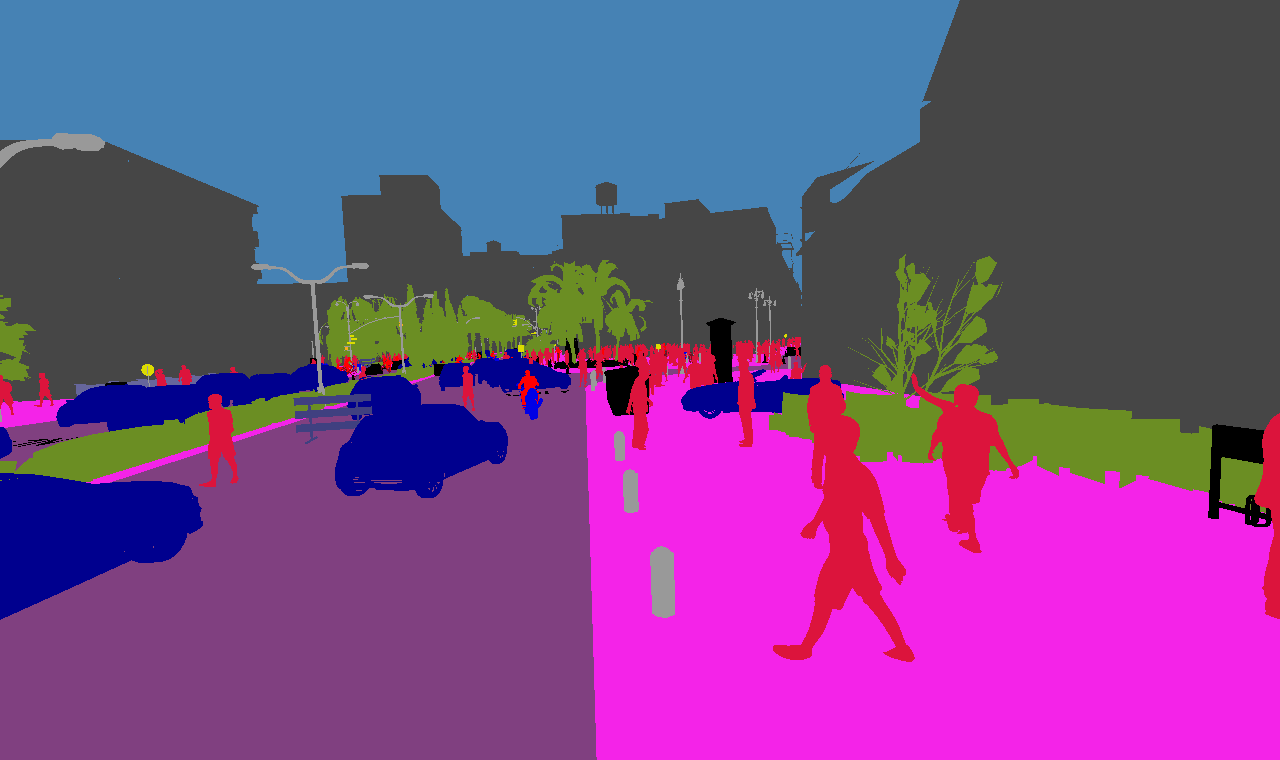

In [ ]:
cv2_imshow(test)

In [ ]:
gt_label = np.asarray(imageio.imread(gt_train +'/'+ test_label_image, format='PNG-FI'))

gt_label[:,:,0][gt_label[:,:,0] == 22] = 3  # lanemarkings ----> road
gt_label[:,:,0][gt_label[:,:,0] == 13] = 3  # parking slot ----> road
gt_label[:,:,0][gt_label[:,:,0] == 14] = 0  # road works ----> void

# #gt_label_one_chan = gt_label[:,:,0]  # Select first channel
# cv2.imwrite( gt_path + '/' + 'SEMANTIC_LABELS/' + file , gt_label)
    
# # Use utils function to convert the pixels to the cityscapes colours
# # save images in the directory we created. 
# img_colour = label_img_to_color_SYNTHIA_BGR(gt_label[:,:,0])
# #cv2_imshow(img_colour)
# cv2.imwrite( gt_path + '/' + 'COLOUR_CITYSCAPES/' + file , img_colour)

# label_img_paths.append( gt_path + '/' + 'SEMANTIC_LABELS/' + file )

In [ ]:

gt = gt_label[:,:,0].astype(np.uint8)
cv2.imwrite('/content/drive/MyDrive/BiasMitigation/Datasets/SYNTHIA/GT/SEMANTIC_LABELS' + '/test.png', gt)

True

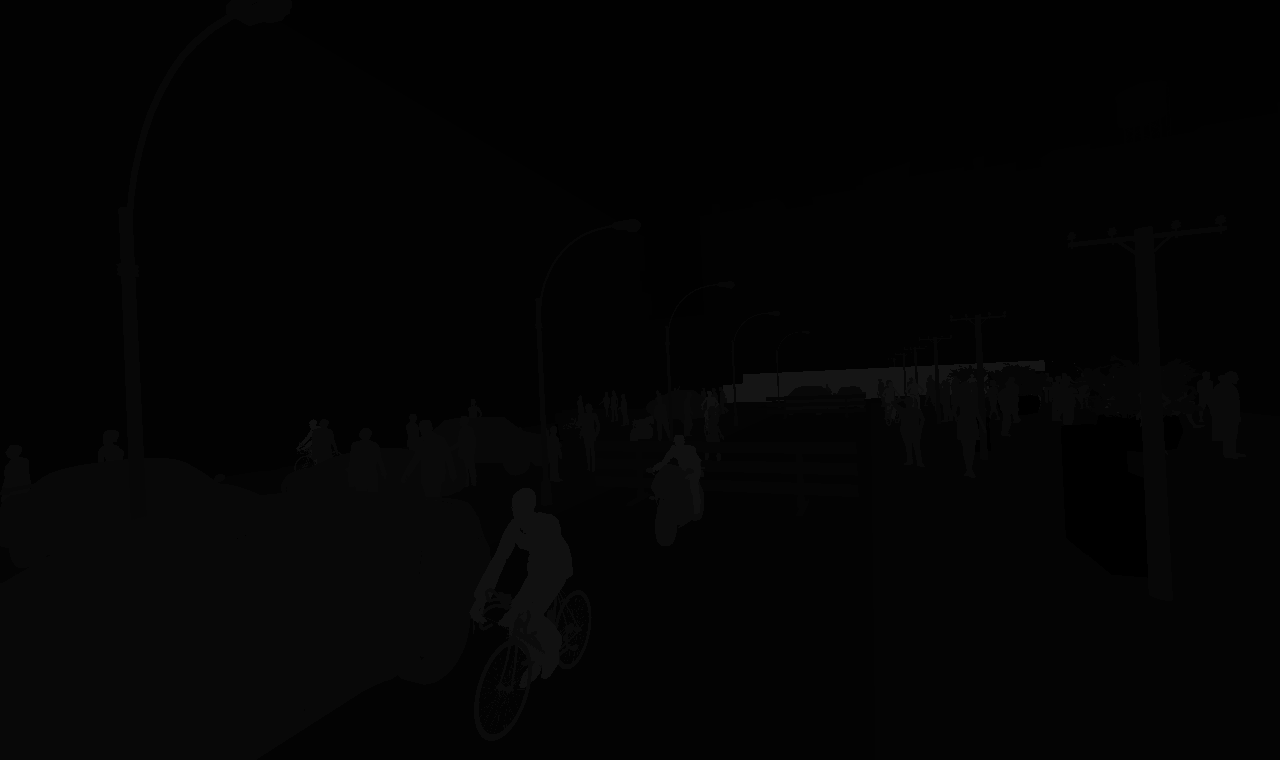

In [ ]:
cv2_imshow(gt_label[:,:,0])

In [ ]:
type(gt_label)

numpy.ndarray

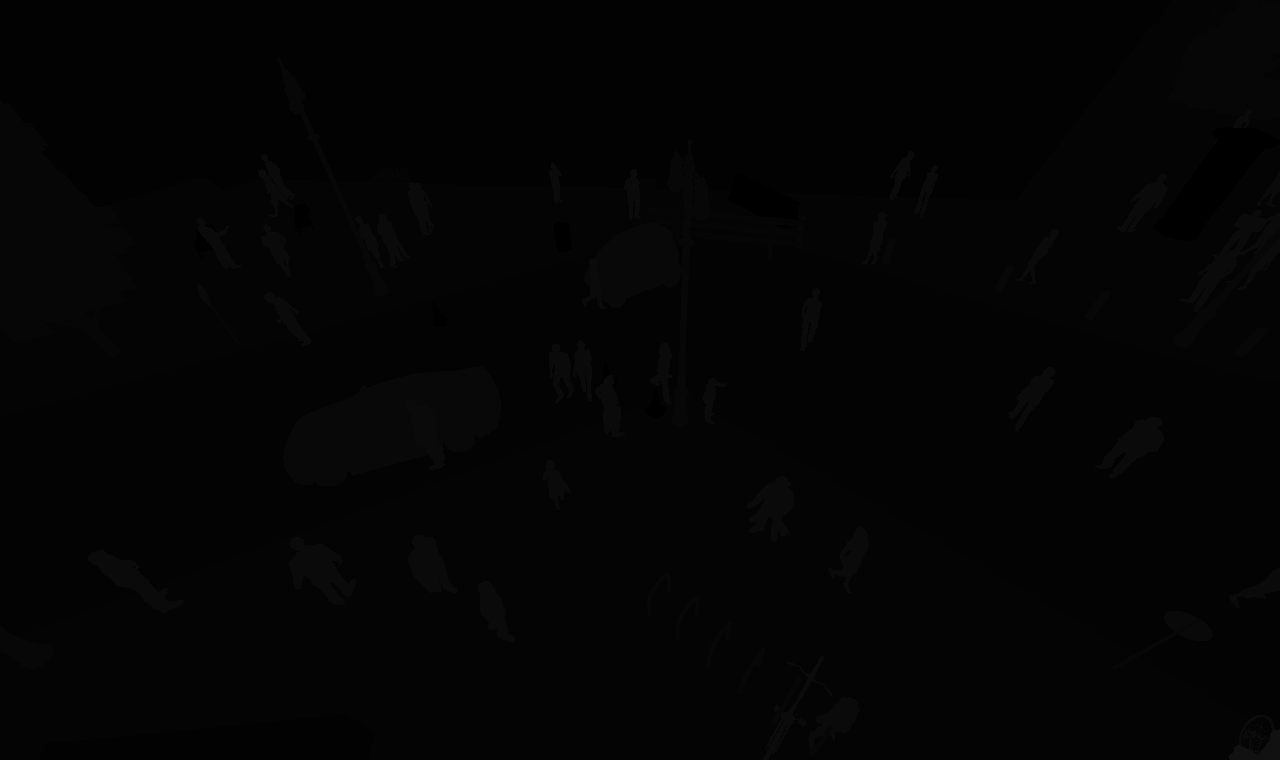

[ 0  2  3  4  5  6  7  8  9 10 11 17]


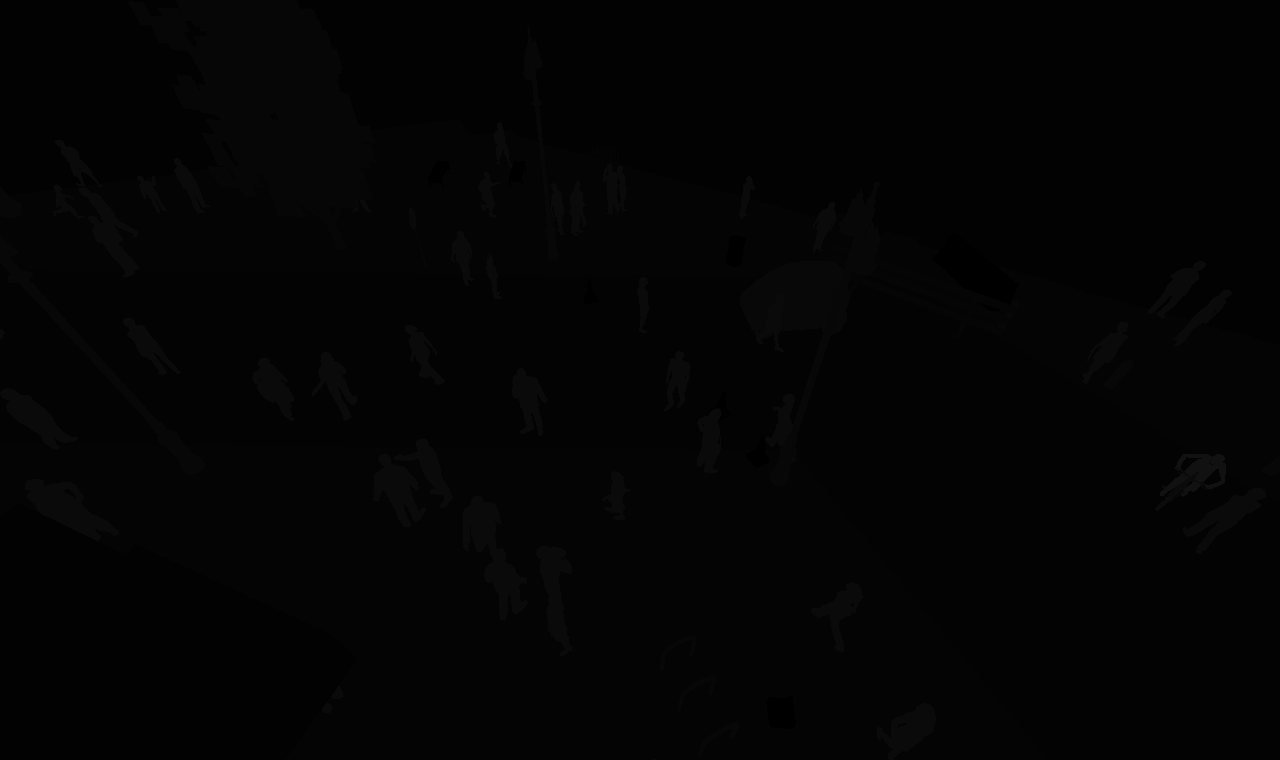

[ 0  2  3  4  5  6  7  8  9 10 11 17]


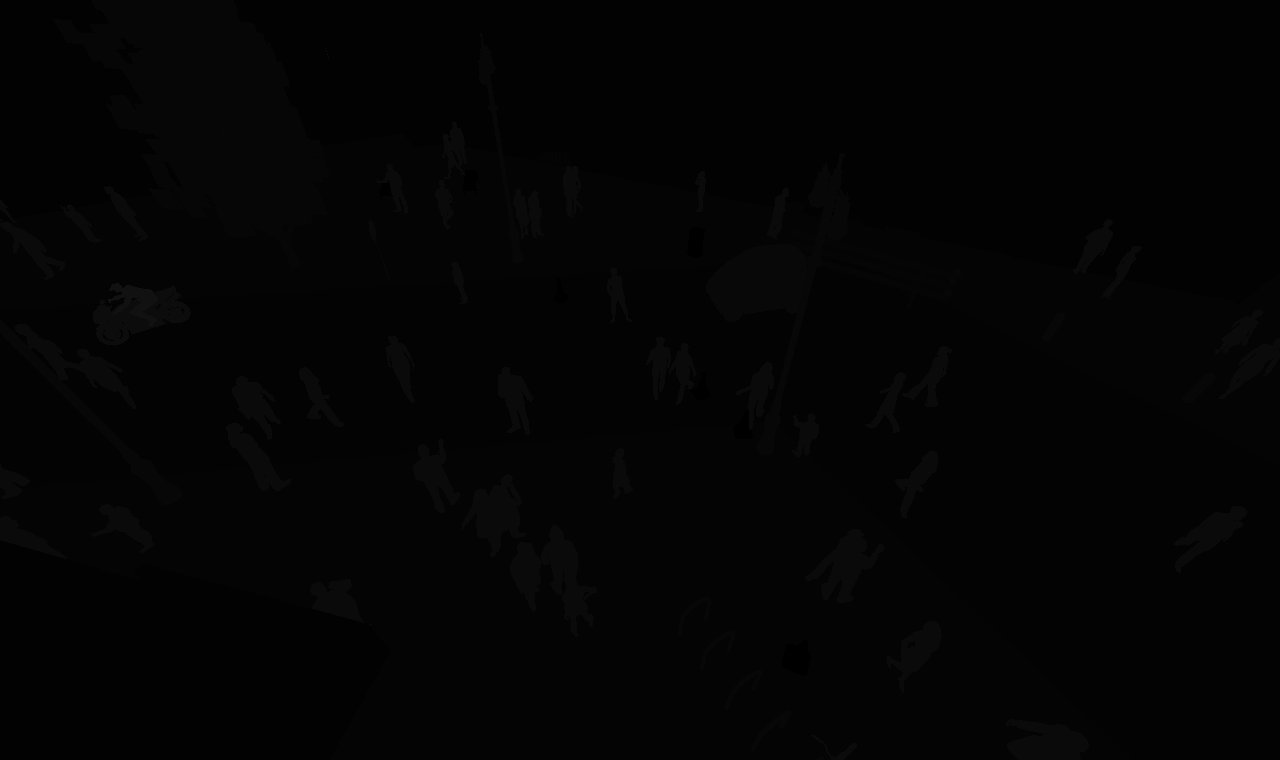

[ 0  2  3  4  5  6  7  8  9 10 11 12 17 19]


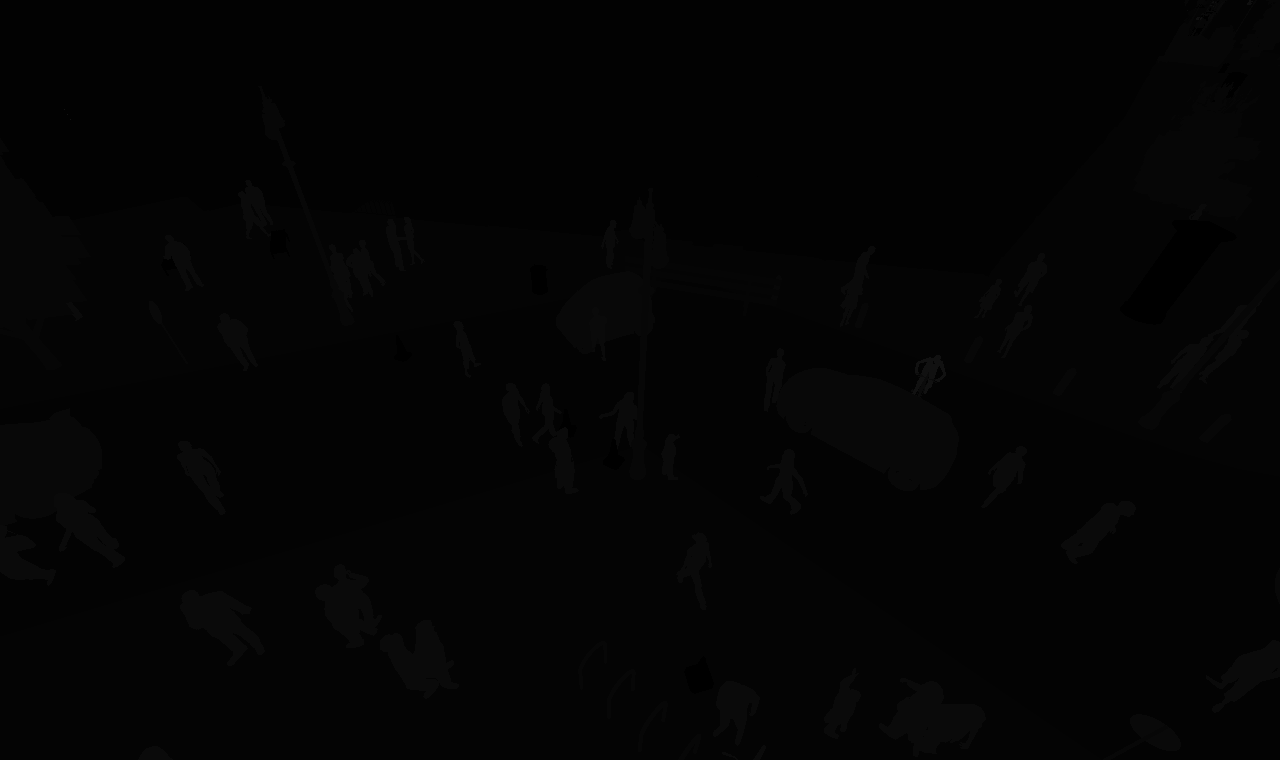

[ 0  2  3  4  5  6  7  8  9 10 11 15 17 19]


In [ ]:
## We must read in all the label images and change the values from 0 - 22 to 0-19 for the network to work:

files = os.listdir(gt_train)

counter = 0
for file in files:
    counter += 1
    img = cv2.imread(gt_train + '/' + file)
    cv2_imshow(img)
    print(np.unique(img))

    if counter == 4:    
        break

In [ ]:
synthia_new_ids = [0,1,2,3,4,5,6,7,8,9,10,11,12,15,16,17,18,19,20,21]
cityscapes_ids = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]

print(len(synthia_new_ids))
print(len(cityscapes_ids))

ids_to_cityscapes = {synthia_new_ids:cityscapes_ids for label }

20
20


In [ ]:
# if larger than 13 replace with -3 of itself... 

label_train_dir = '/content/drive/MyDrive/BiasMitigation/Datasets/SYNTHIA/GT/SEMANTIC_LABELS/train'
label_val_dir = '/content/drive/MyDrive/BiasMitigation/Datasets/SYNTHIA/GT/SEMANTIC_LABELS/val'

train_files = os.listdirs(label_train_dir)

for file in train_files:
    labels = cv2.imread(label_train_dir + '/' + file, -1)
    if label[:,:,0][label[:,:,0] > 12] :
        label[:,:,0][label[:,:,0]] 

    gt_label[:,:,0][gt_label[:,:,0] == 22] = 3  # lanemarkings ----> road
gt_label[:,:,0][gt_label[:,:,0] == 13] = 3  # parking slot ----> road
gt_label[:,:,0][gt_label[:,:,0] == 14] = 0  # road works ----> void
    

[ 0  1  2  3  4  5  8 10 11 12 13 17 18 19]
(760, 1280)


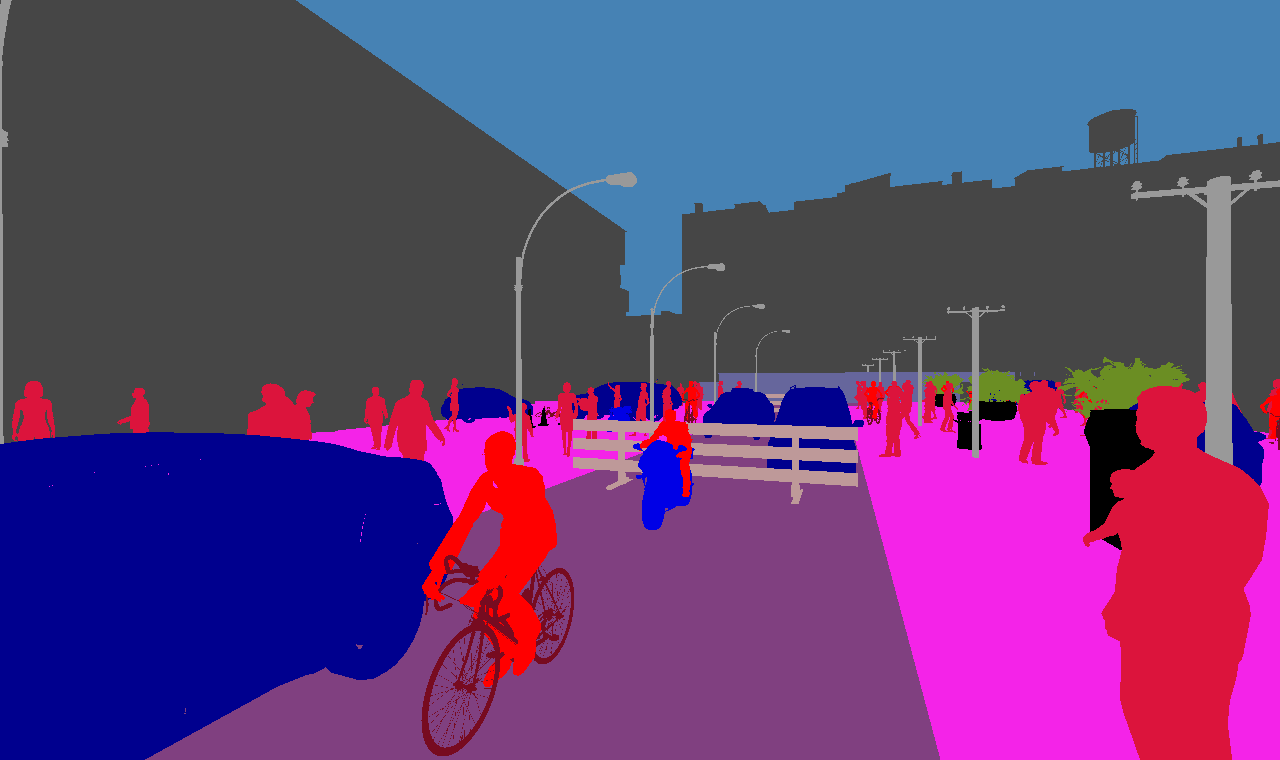

[ 0  1  2  3  4  5  8 10 11 12 13 17 18 19]
(760, 1280)


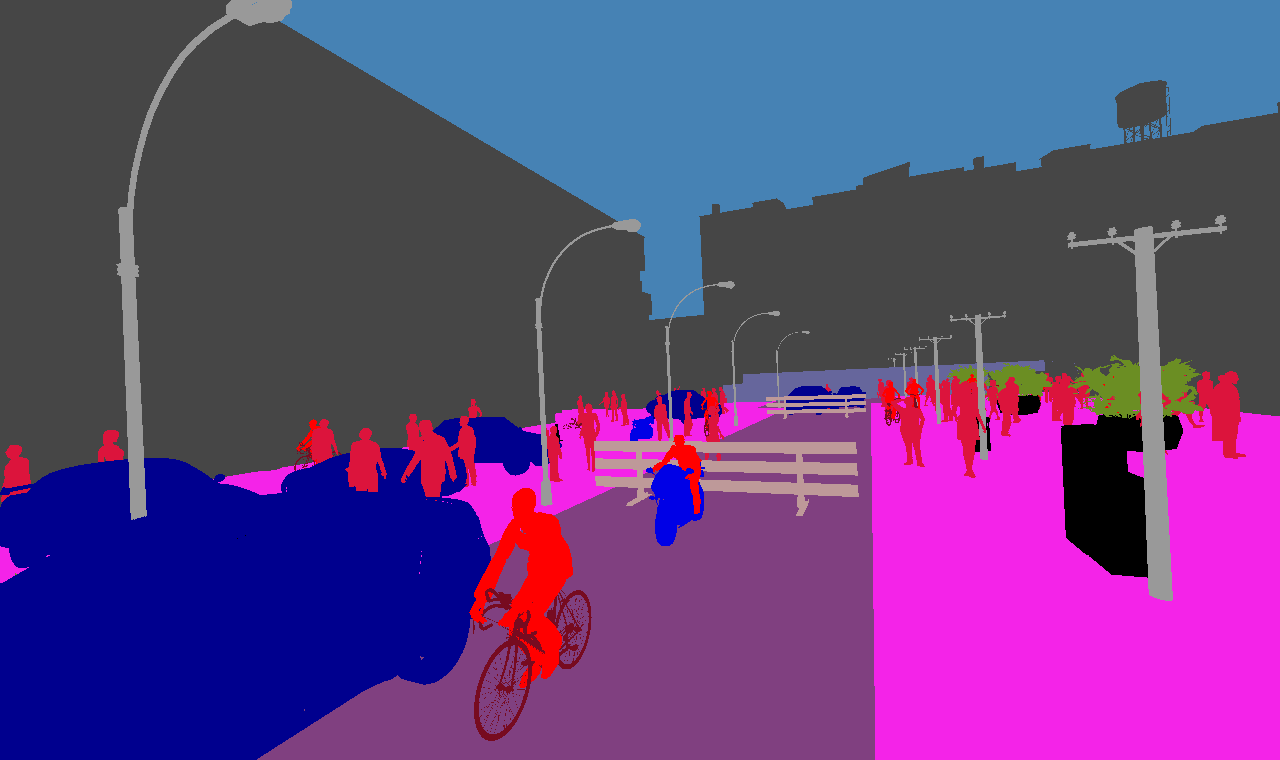

[ 0  1  2  3  4  5  8 10 11 12 13 17 18 19]
(760, 1280)


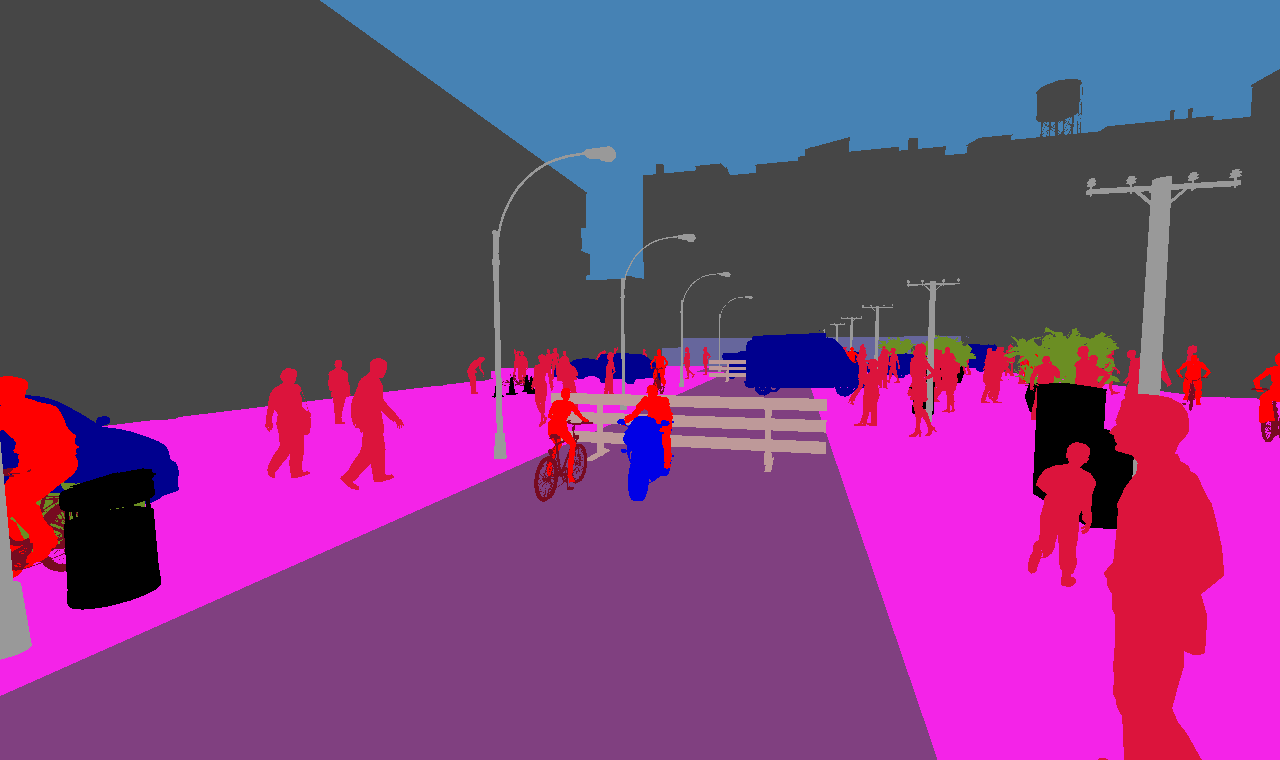

[ 0  1  2  3  4  5  8 10 11 12 13 17 18 19]
(760, 1280)


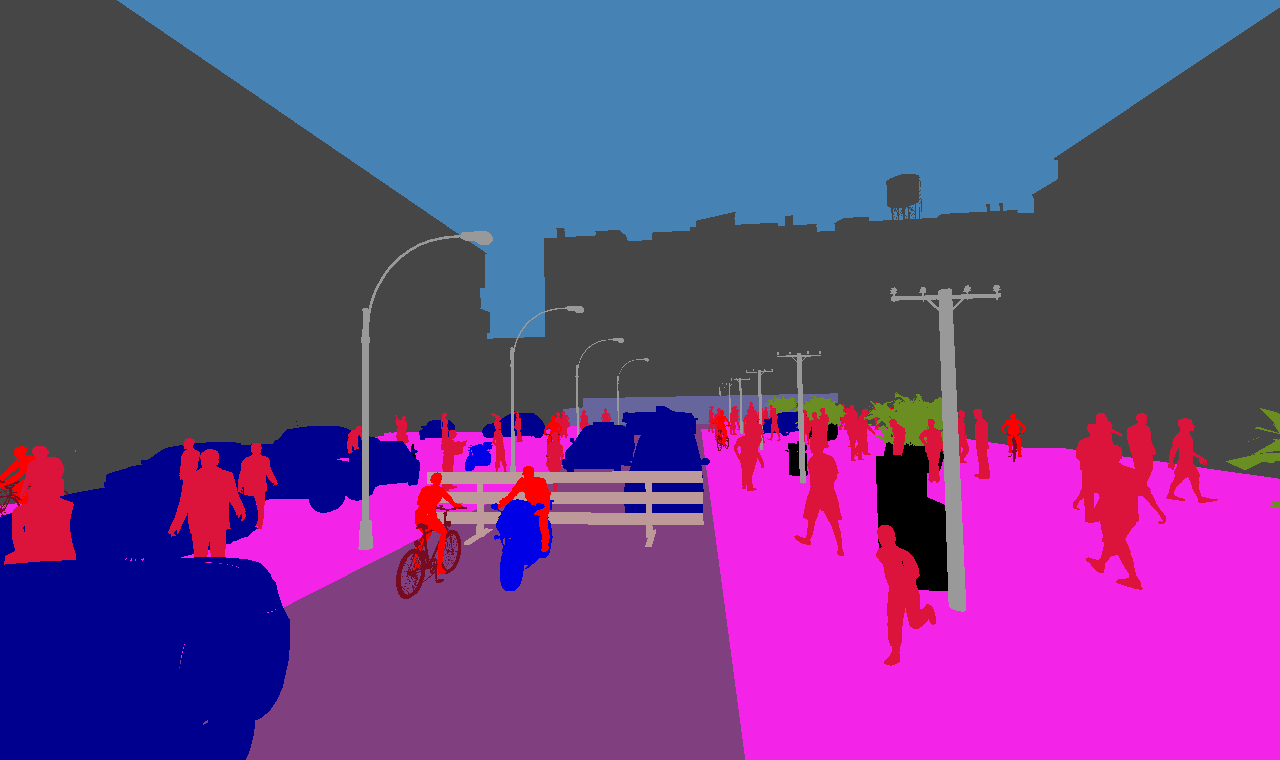

[ 0  1  2  3  5  8 10 11 12 13 15 17 18 19]
(760, 1280)


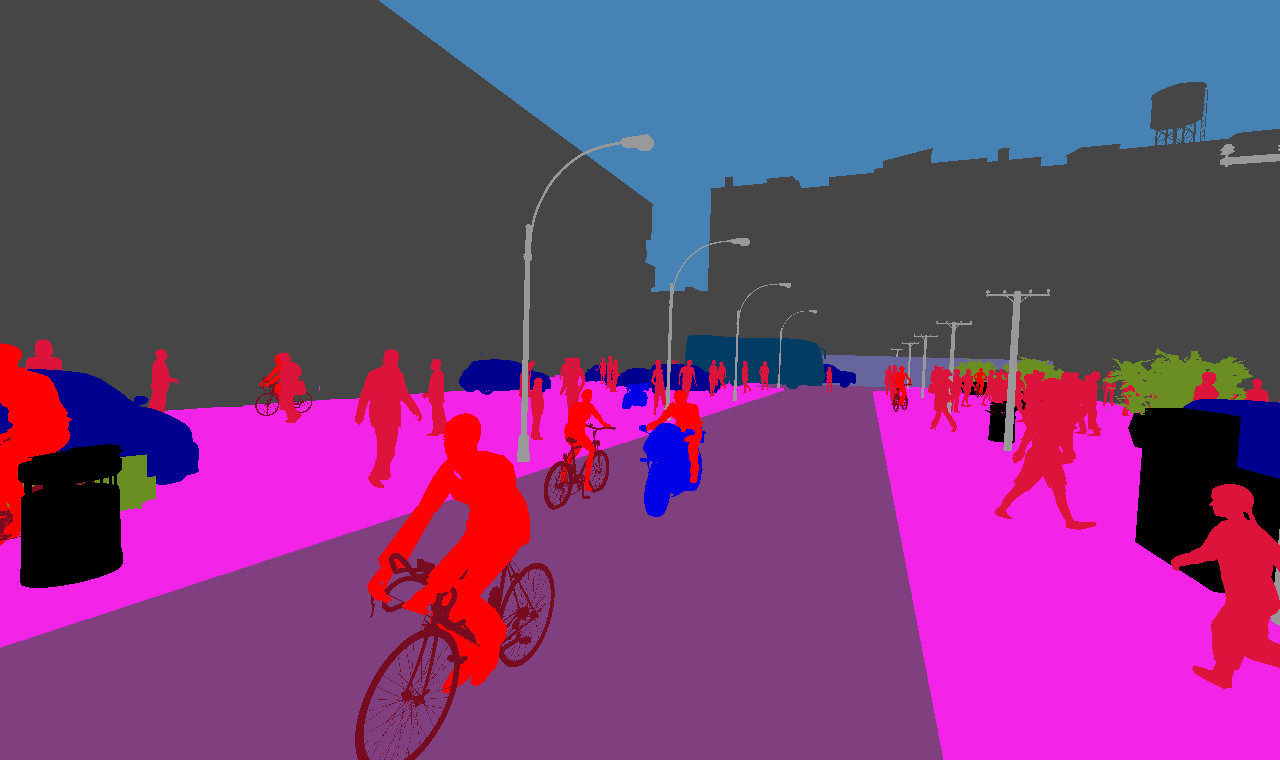

[ 0  1  2  3  4  5  8 10 11 12 13 15 17 18 19]
(760, 1280)


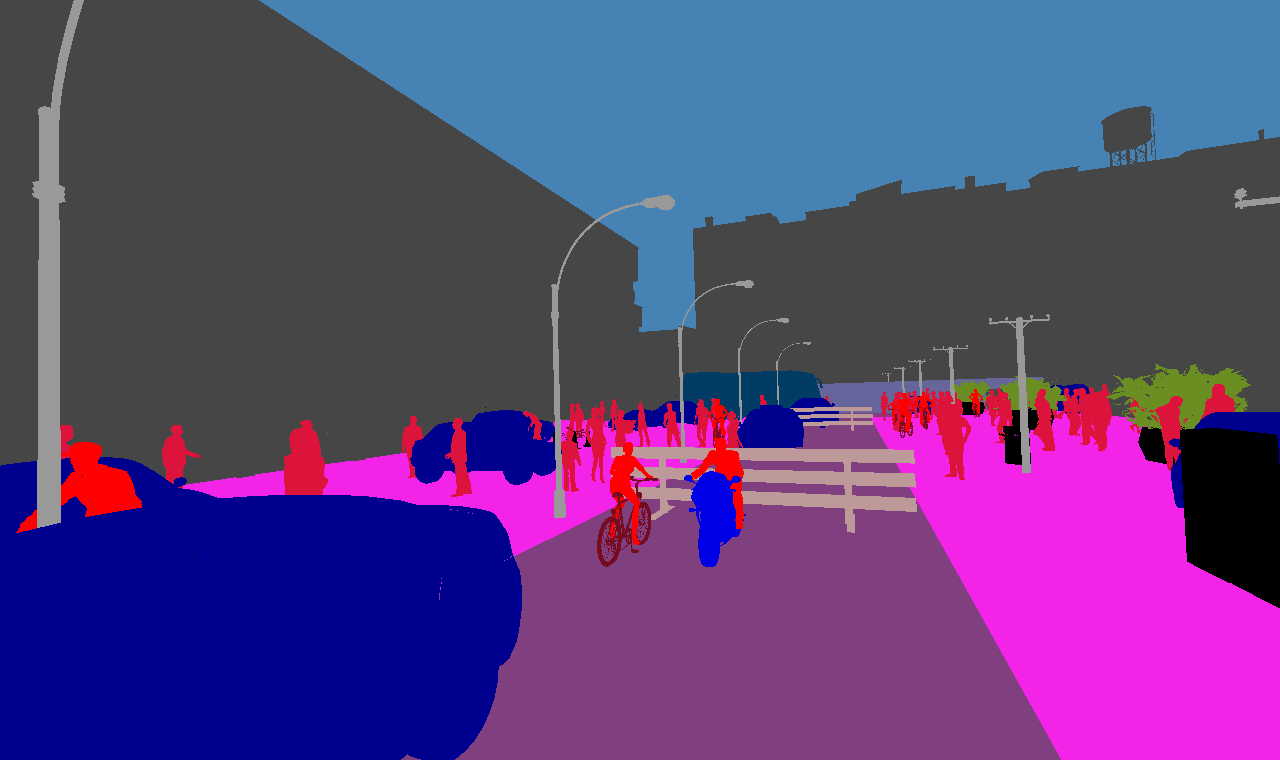

[ 0  1  2  3  4  5  8 10 11 12 13 17 18 19]
(760, 1280)


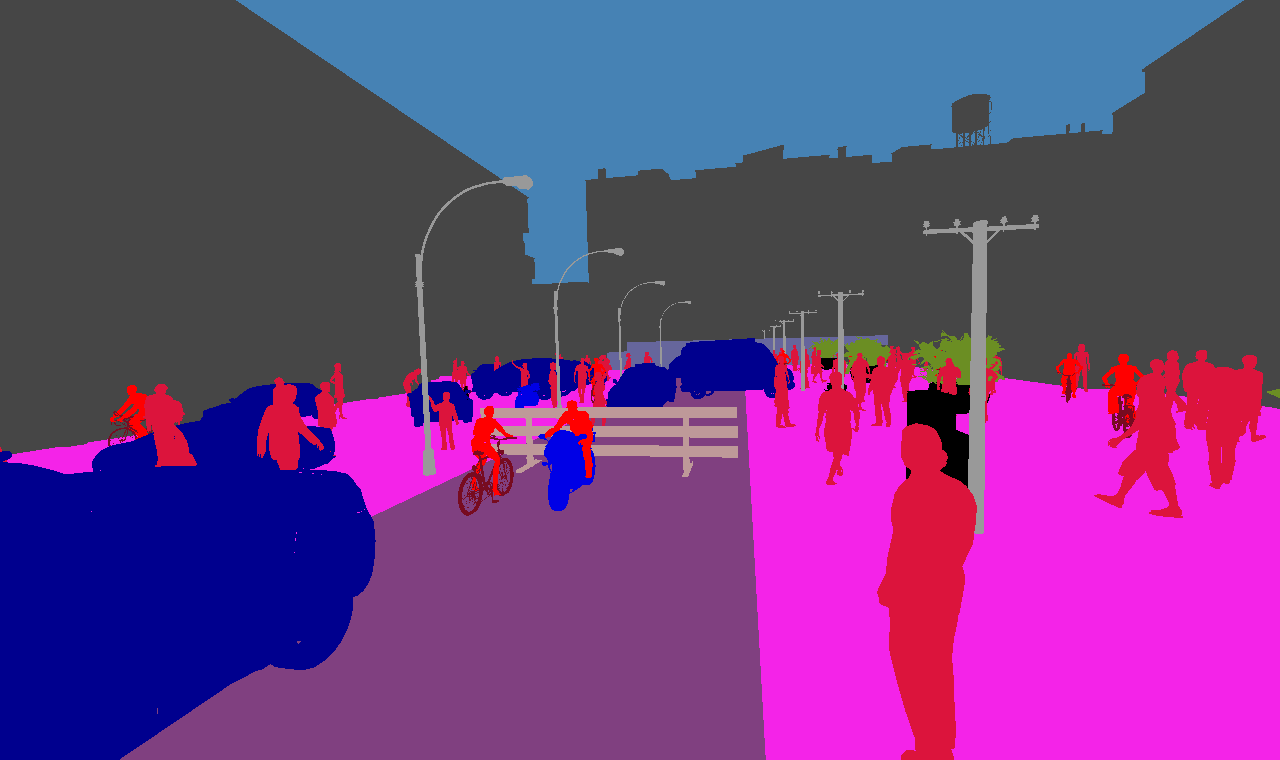

[ 0  1  2  3  4  5  8 10 11 12 13 15 17 18 19]
(760, 1280)


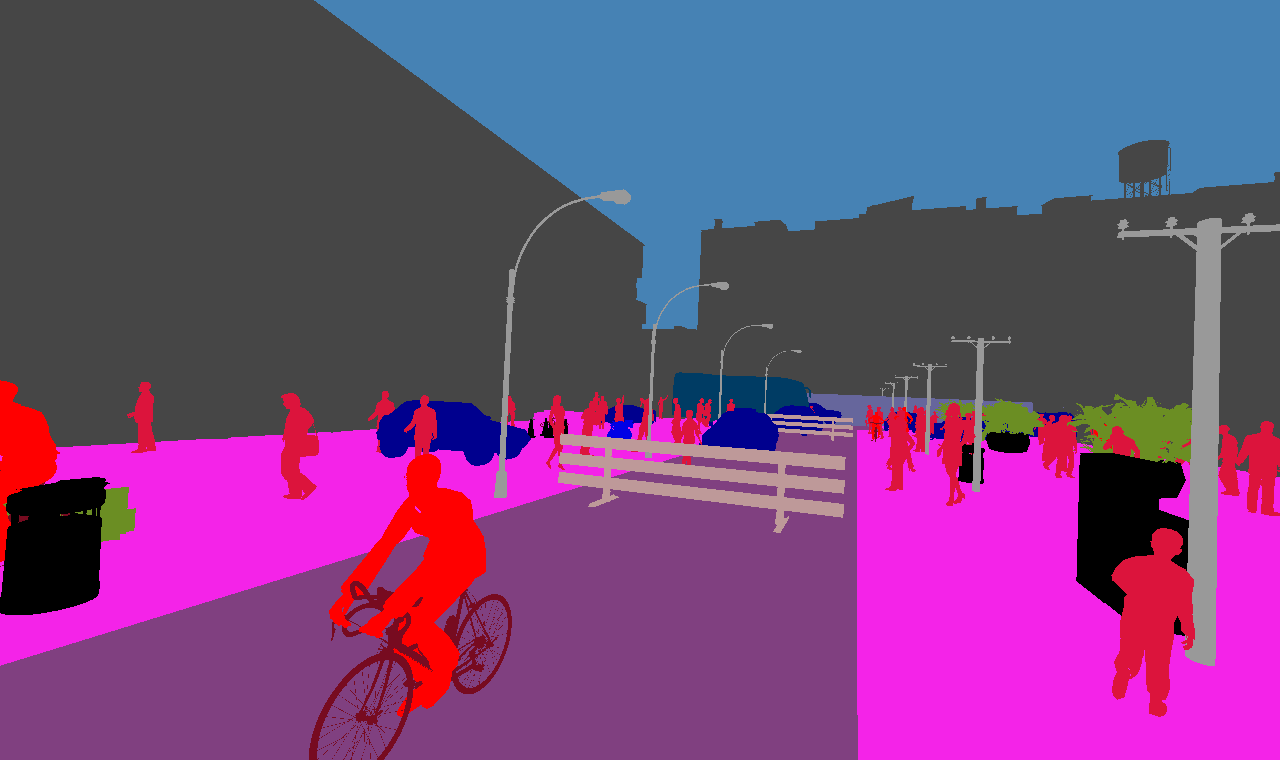

[ 0  1  2  3  4  5  8 10 11 12 13 15 17 18 19]
(760, 1280)


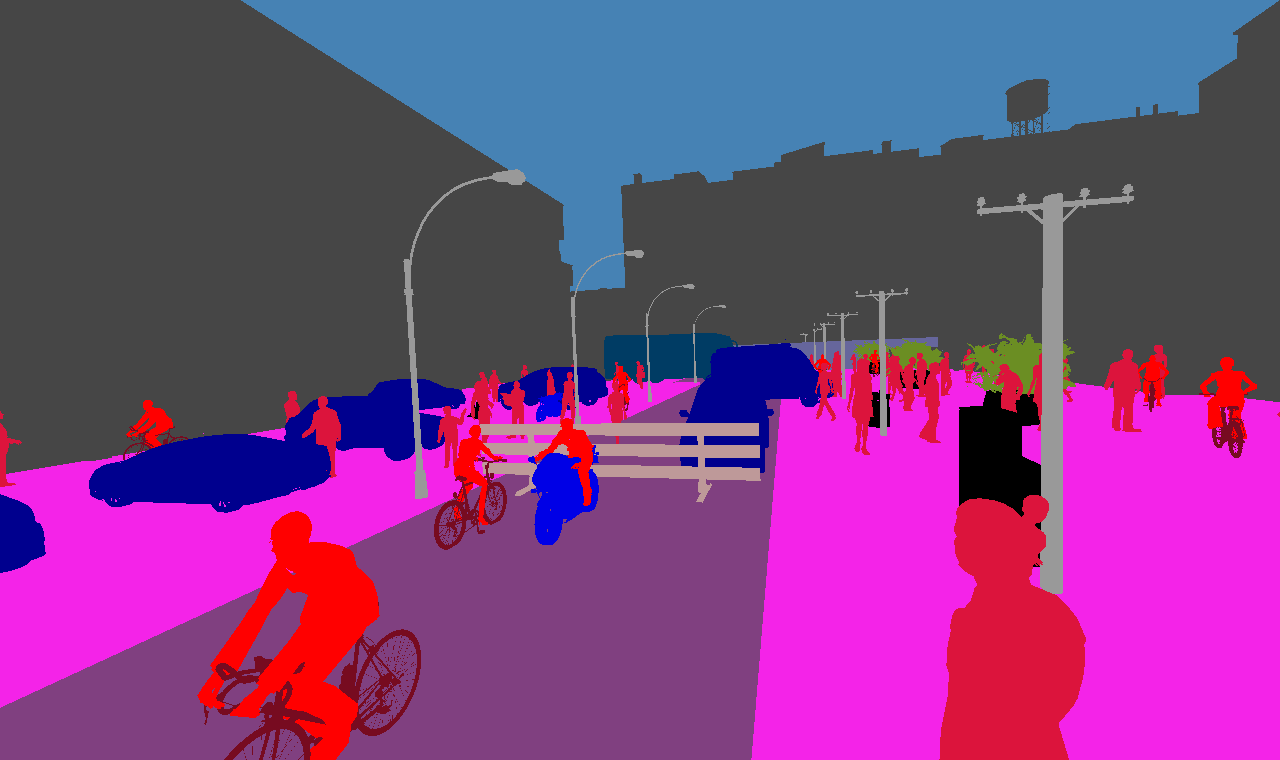

[ 0  1  2  3  4  5  8 10 11 12 13 15 17 18 19]
(760, 1280)


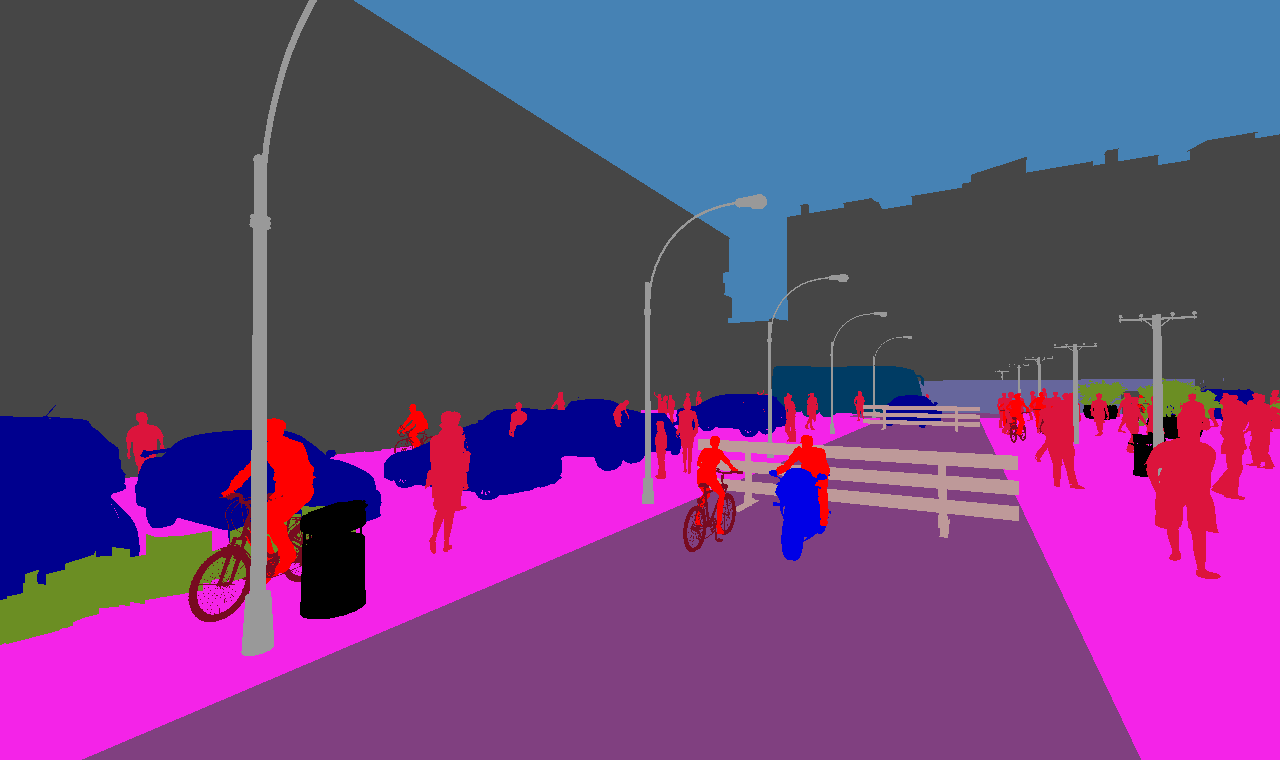

[ 0  1  2  3  4  5  8 10 11 12 13 15 17 18 19]
(760, 1280)


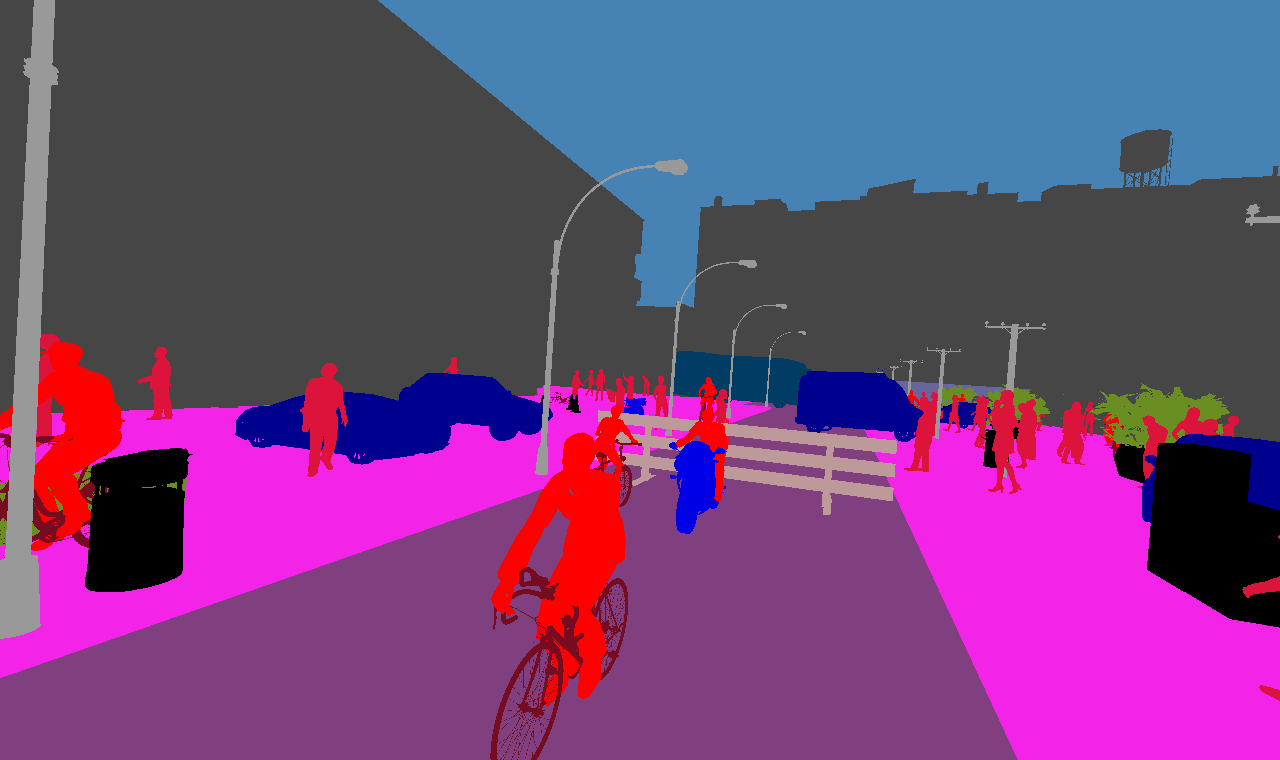

[ 0  1  2  3  4  5  8 10 11 12 13 17 18 19]
(760, 1280)


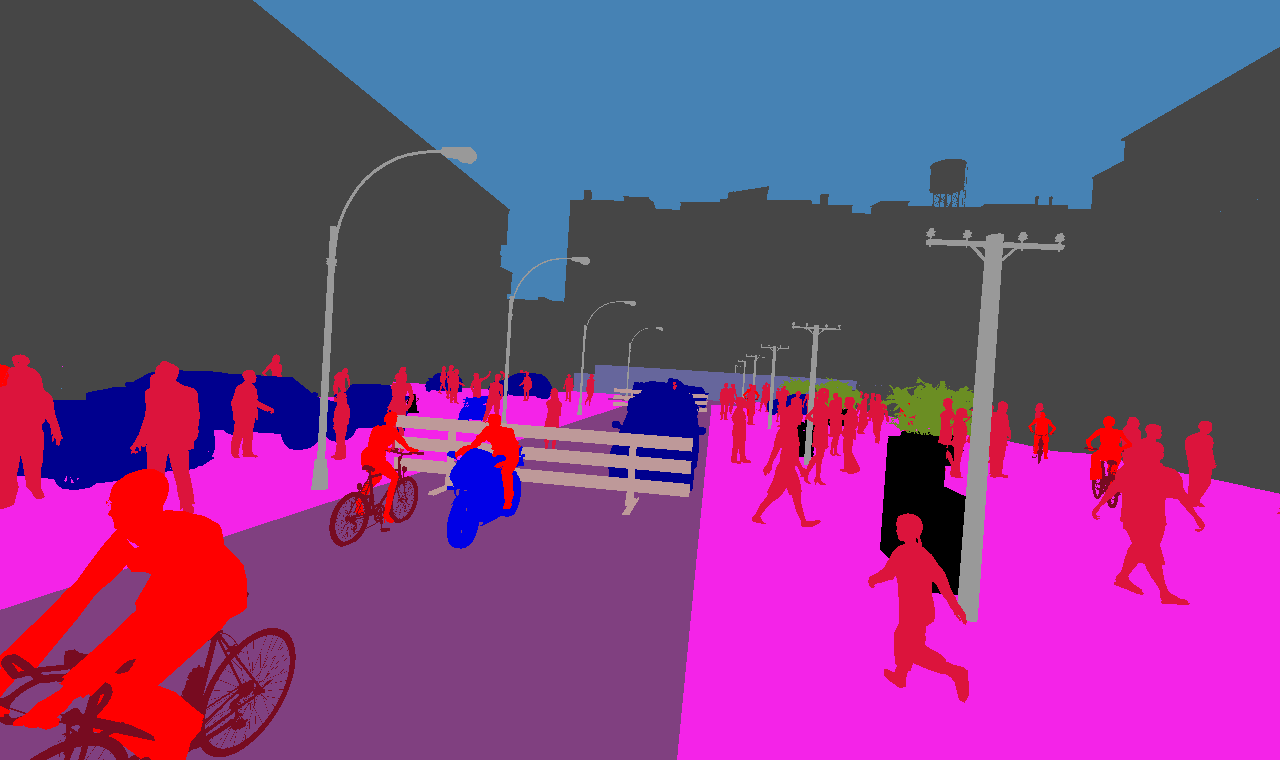

[ 0  1  2  3  5  8 10 11 12 13 17 18 19]
(760, 1280)


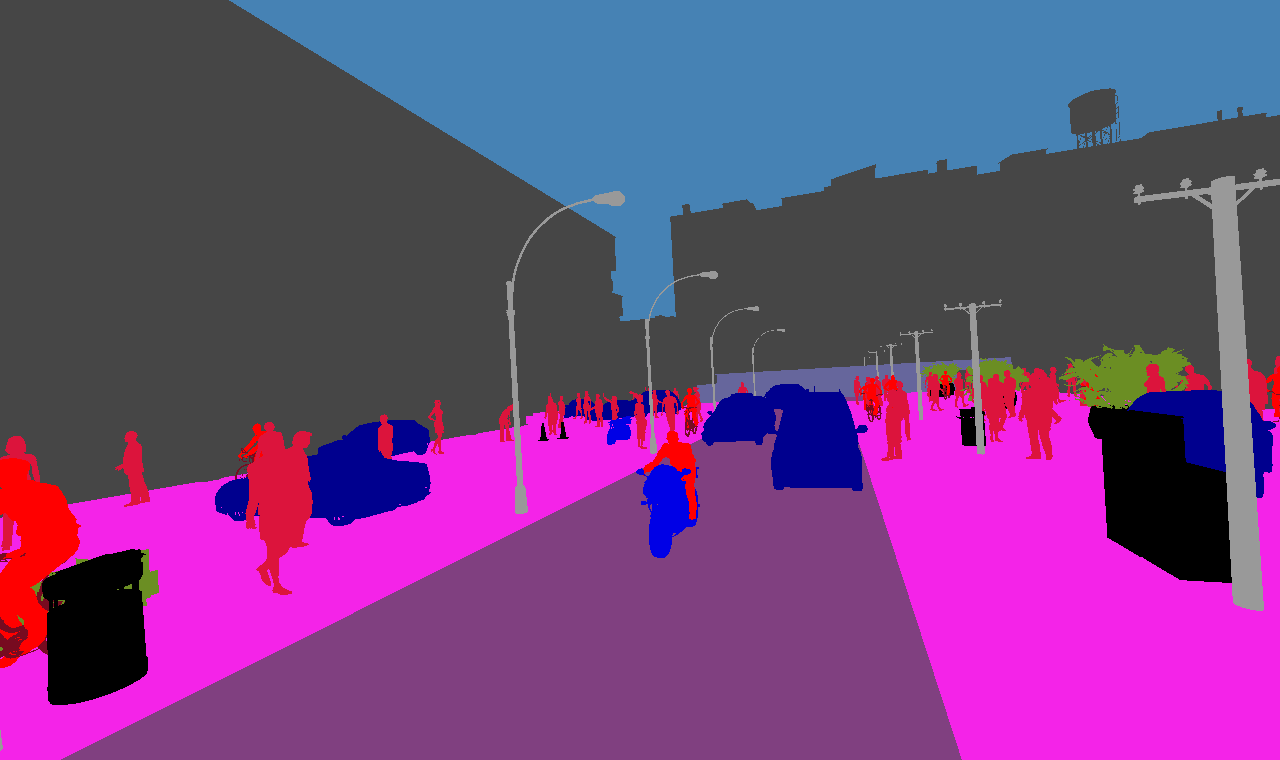

[ 0  1  2  3  4  5  8 10 11 12 13 15 17 18 19]
(760, 1280)


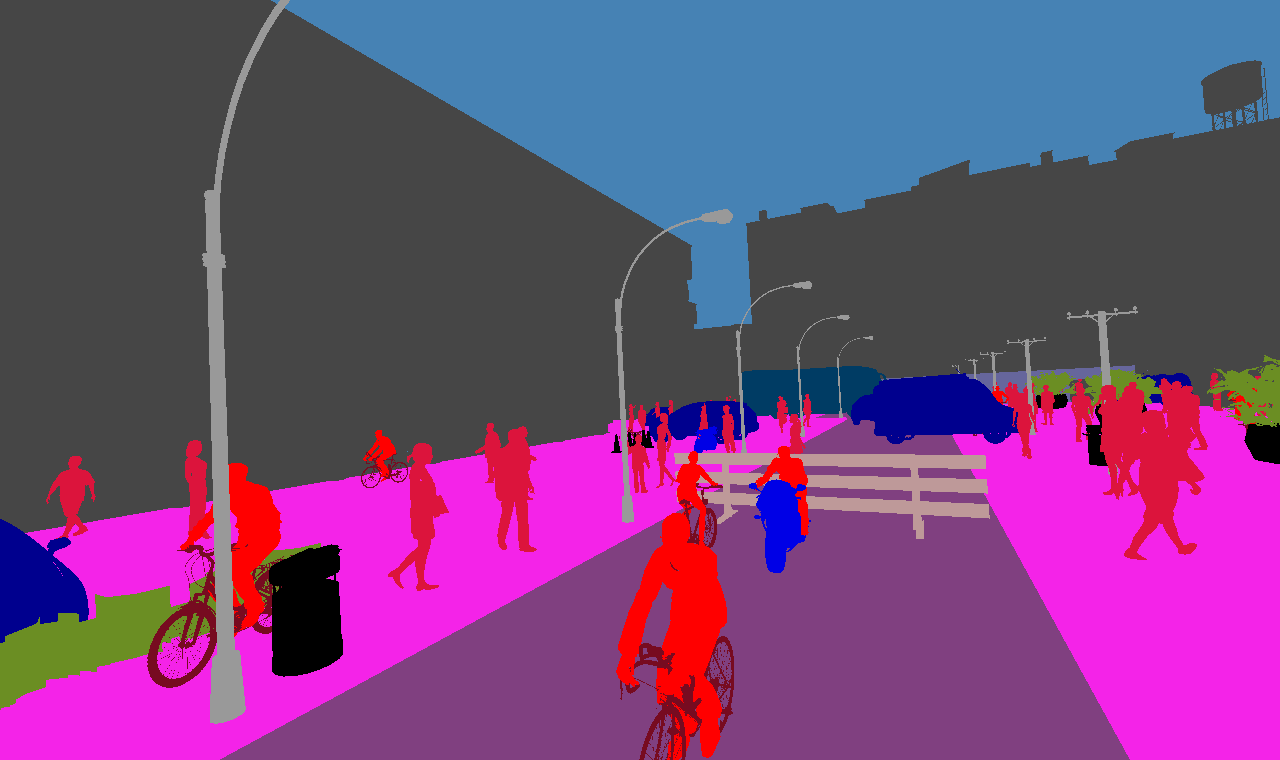

[ 0  1  2  3  5  8 10 11 12 13 15 17 18 19]
(760, 1280)


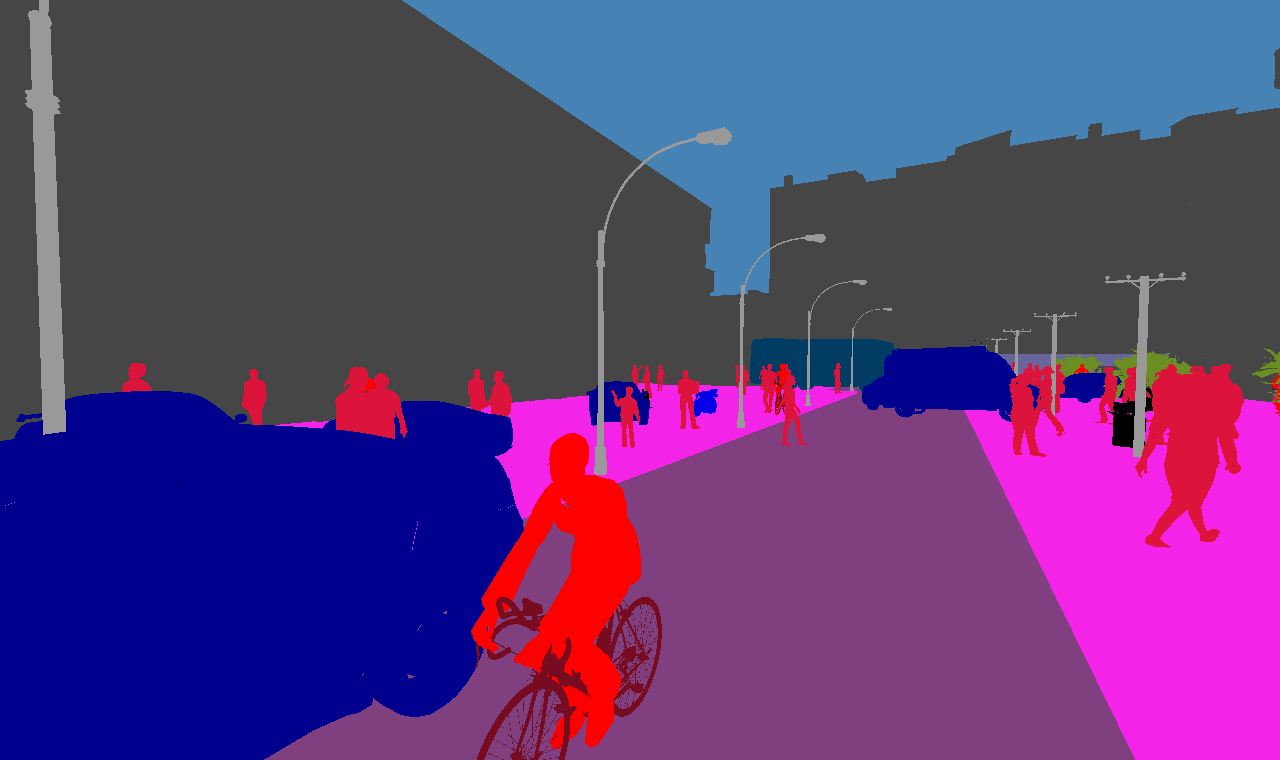

[ 0  1  2  3  4  5  8 10 11 12 13 15 17 18 19]
(760, 1280)


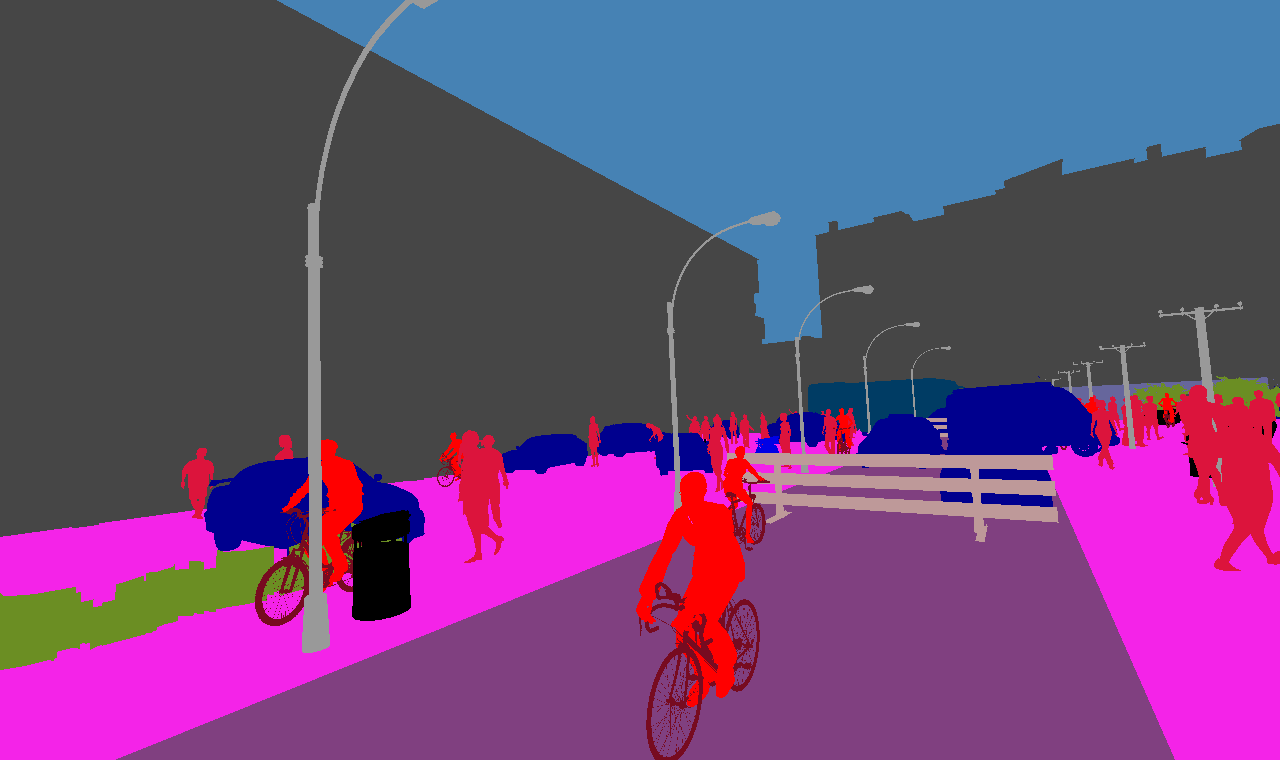

[ 0  1  2  3  4  5  8 10 11 12 13 17 18 19]
(760, 1280)


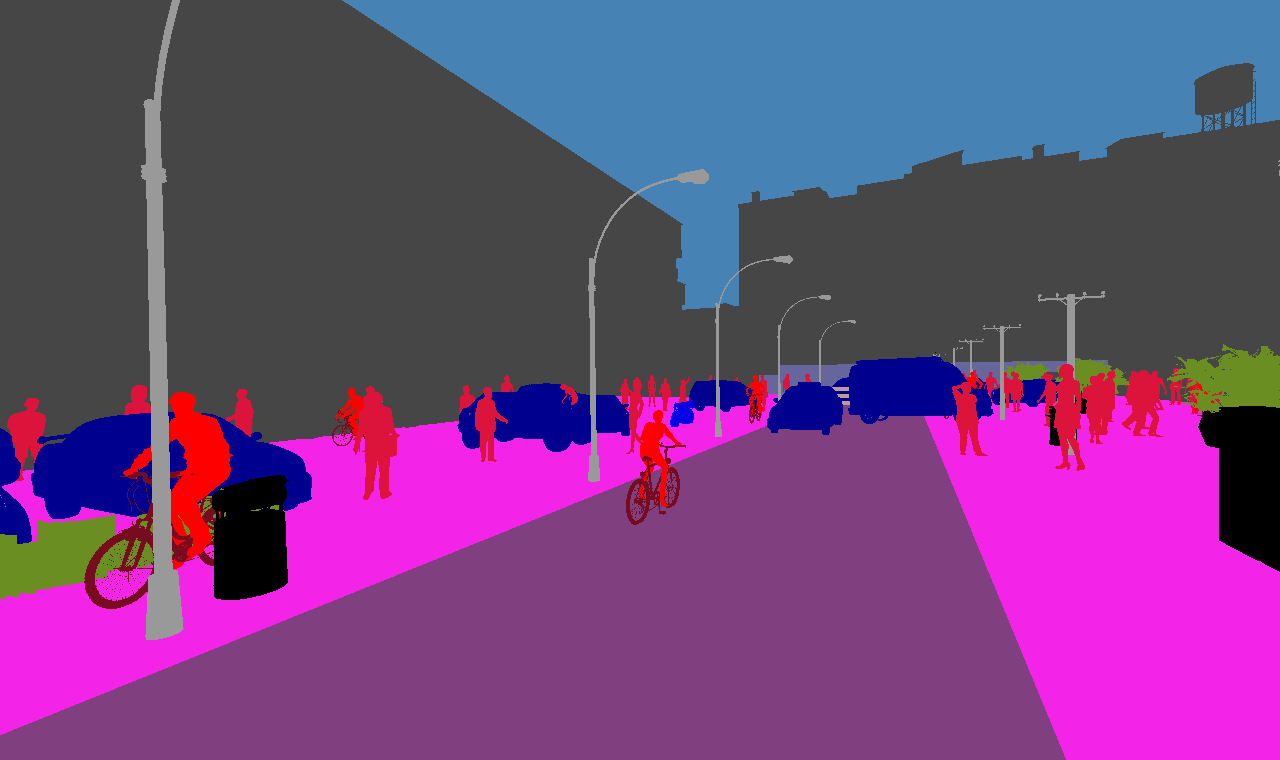

[ 0  1  2  3  4  5  8 10 11 12 13 17 18 19]
(760, 1280)


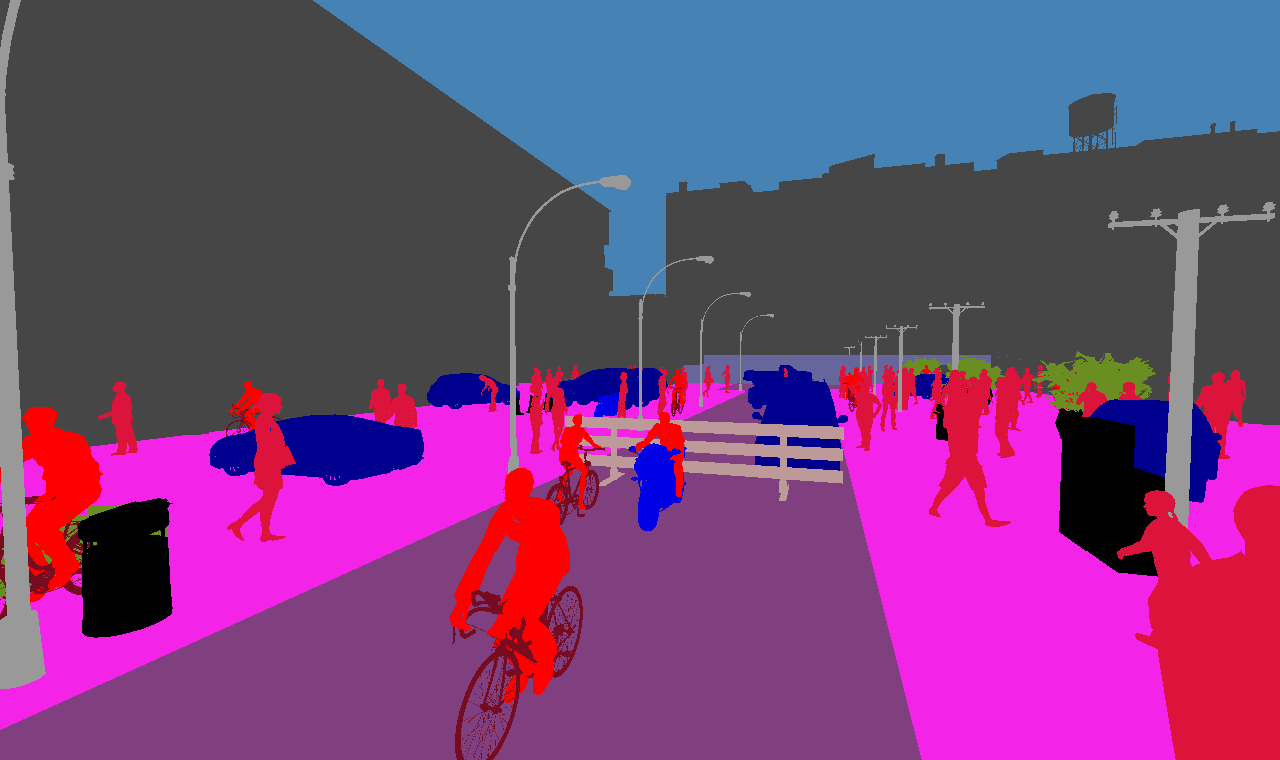

[ 0  1  2  3  5  8 10 11 12 13 17 18 19]
(760, 1280)


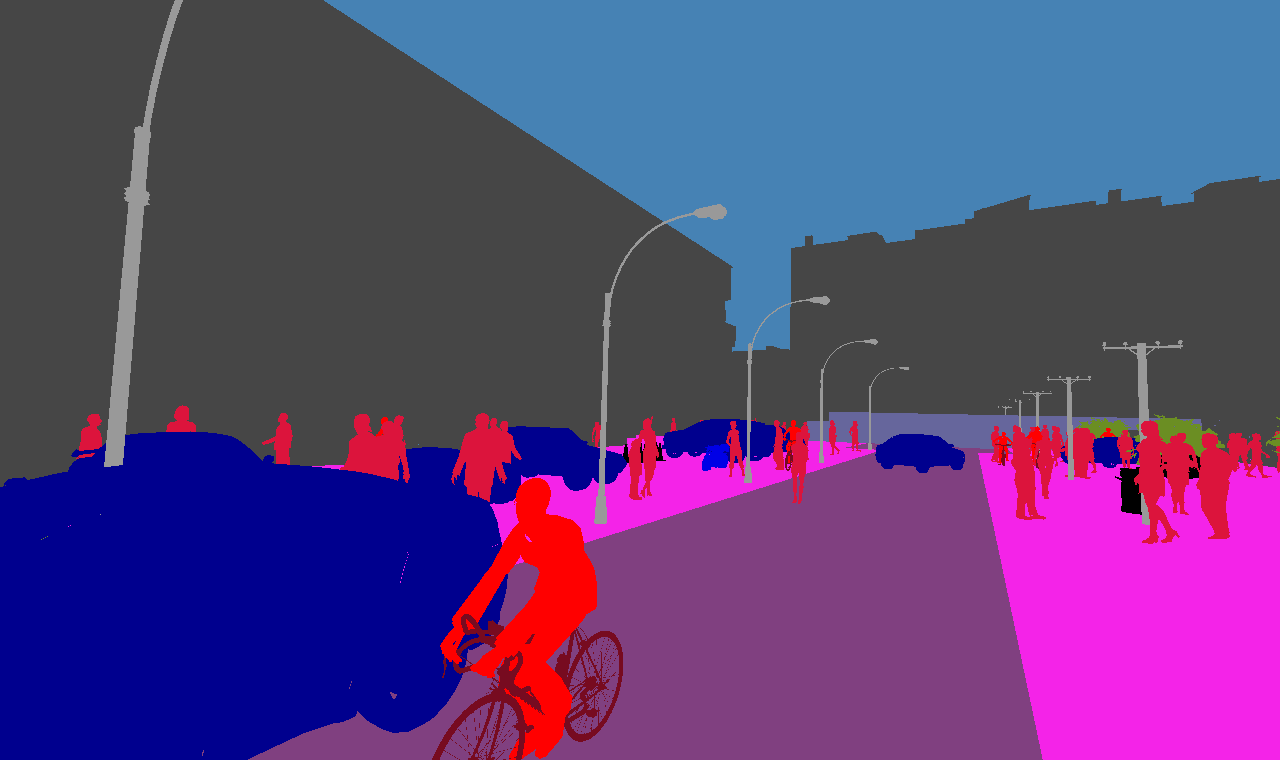

[ 0  1  2  3  4  5  8 10 11 12 13 17 18 19]
(760, 1280)


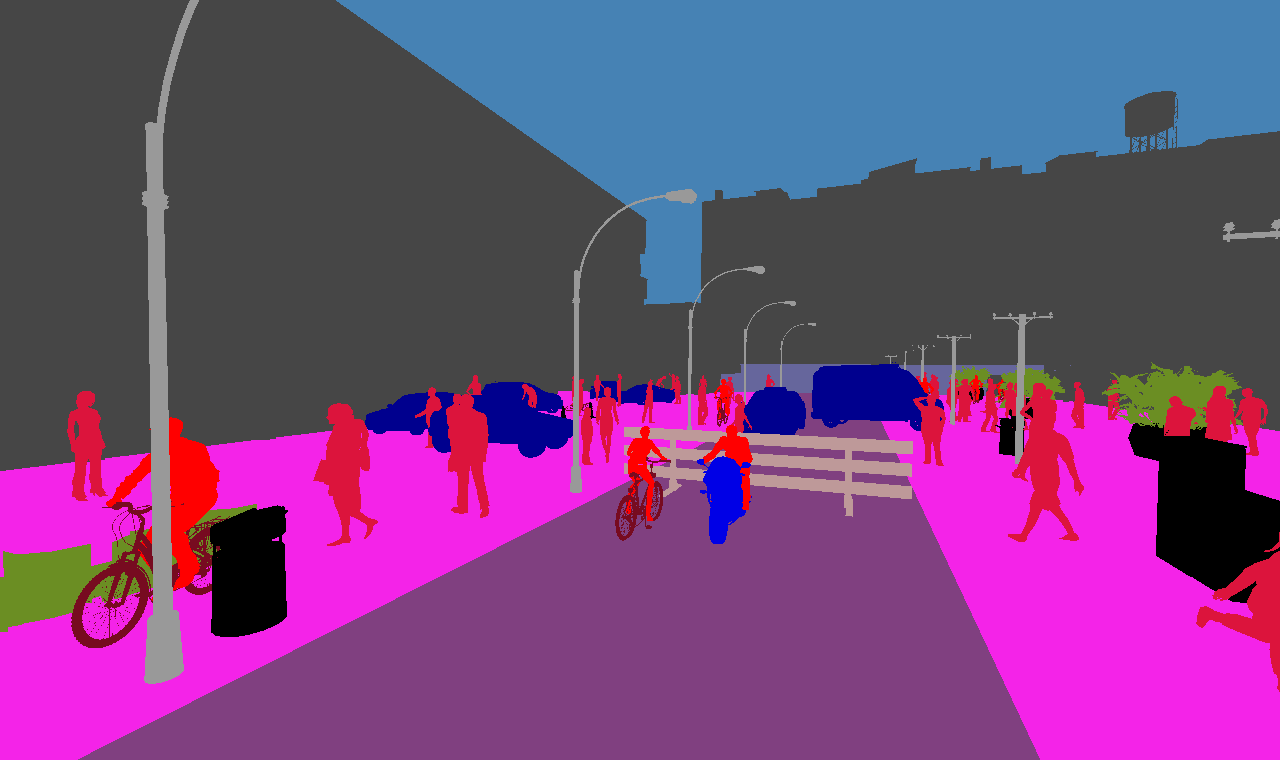

[ 0  1  2  3  4  5  8 10 11 12 13 15 17 18 19]
(760, 1280)


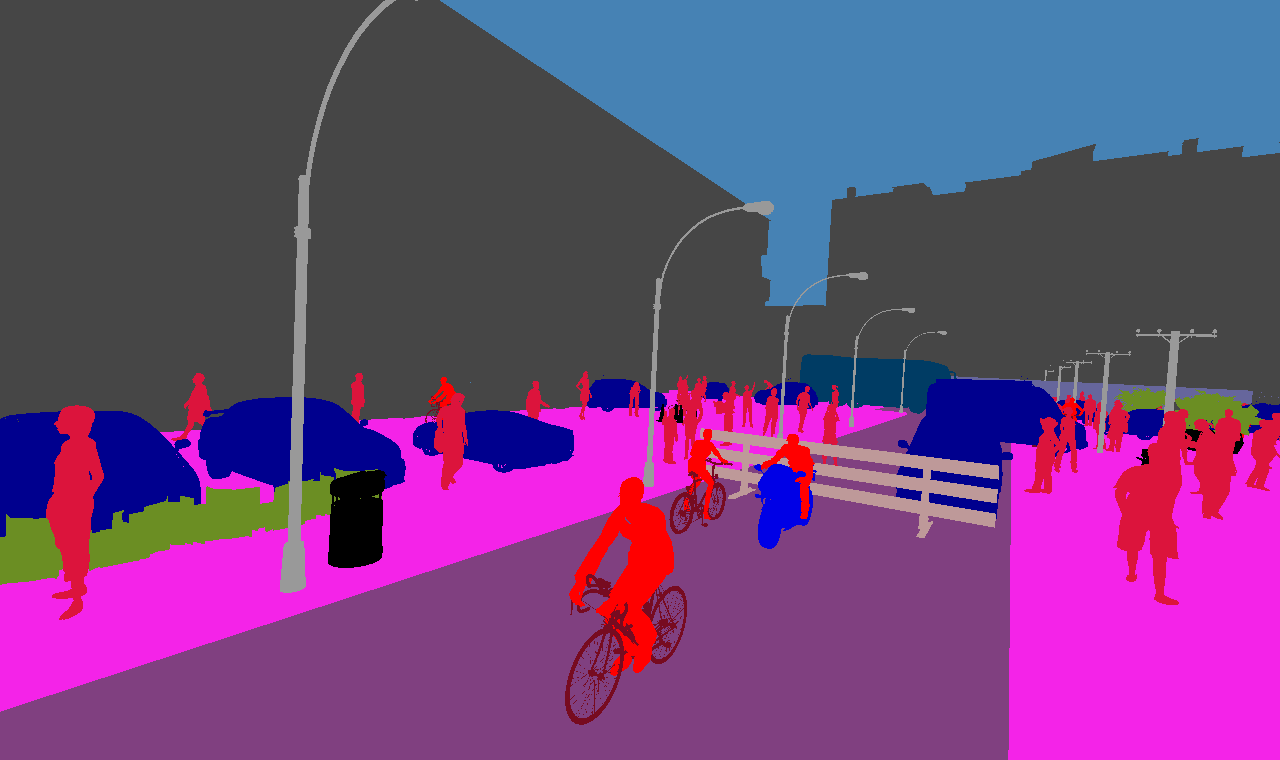

In [19]:
# test the above code works:
#provide test image from label path
import os
import torch
import torch.utils.data
import torchvision.transforms as T

import pickle 
import numpy as np
import cv2
import os
import shutil

# in file ipynb imports for colab
! pip install import-ipynb 
import import_ipynb
from utils.utils_SYNTHIA import *

from google.colab.patches import cv2_imshow
!pip install imageio
import imageio

imageio.plugins.freeimage.download()

# gt_train = '/content/drive/MyDrive/BiasMitigation/Datasets/SYNTHIA/GT/LABELS'
# test_label_image = os.listdir(gt_train)[1]

# print(test_label_image)
# label = cv2.imread(gt_train +'/'+ test_label_image)
# cv2_imshow(label)
# print(label.shape)


img_path = '/content/drive/MyDrive/BiasMitigation/Datasets/SYNTHIA/RGB'
gt_path = '/content/drive/MyDrive/BiasMitigation/Datasets/SYNTHIA/GT'

#label_img_paths = [] # Used for the class weights below
gt_instance_label_imgs = os.listdir(gt_path + '/LABELS')

# label images in the cityscapes synthia dataset are for instance segmentation so we have to strip out the 
# first channel of the label image and reproduce the coloured ground truth images for semantic segmentation
if not os.path.exists(gt_path + '/' + 'TESTING'):
    os.makedirs(gt_path + '/' + 'TESTING')

for i, file in enumerate(sorted(gt_instance_label_imgs)):

    gt_label = np.asarray(imageio.imread(gt_path +'/LABELS/'+ file, format='PNG-FI'))

    # if we want to match it up with cityscapes exactly then we can change lanemarkings ----> road, parking slot ----> road, road works ----> void
    # gt_label[:,:,0][gt_label[:,:,0] == 22] = 3  # lanemarkings ----> road
    # gt_label[:,:,0][gt_label[:,:,0] == 13] = 3  # parking slot ----> road
    # gt_label[:,:,0][gt_label[:,:,0] == 14] = 0  # road works ----> void
    
    gt = gt_label[:,:,0].astype(np.uint8) # crucial line for saving
    test = id_to_trainId_map_func(gt)

    print(np.unique(test))
    print(test.shape)
    #gt_label_one_chan = gt_label[:,:,0]  # Select first channel
    cv2.imwrite( gt_path + '/' + 'TESTING/' + file , test)
    
    # Use utils function to convert the pixels to the cityscapes colours
    # save images in the directory we created. 
    img_colour = label_img_to_color_BGR(test)
    cv2_imshow(img_colour)
    cv2.imwrite( gt_path + '/' + 'TESTING/colour_' + file , img_colour)

    if i == 20:
        break